In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


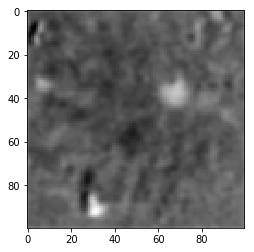

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'fullSess02' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 1000
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
dr = 0.4 #dropout rate
pre_pad_type = "SYMMETRIC"
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


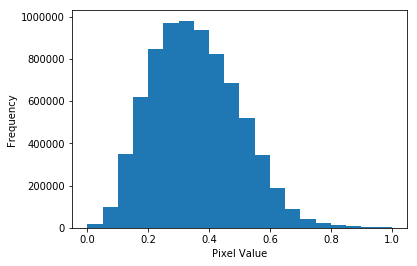

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


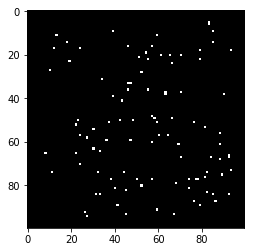

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size, pre_pad_type):
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord=tf.pad(inps, paddings, pre_pad_type)
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    act1=tf.keras.layers.ReLU()(coord1)
    pool1=MaxPooling2D((2, 2), padding='same')(act1)
    drop01 = Dropout(dr)(pool1) #dropout
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord3=tf.pad(drop01, paddings2, pre_pad_type)
    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu')(coord3)
    pool2=MaxPooling2D((2, 2),padding='same')(conv1)
    drop02= Dropout(dr)(pool2)
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord5=tf.pad(drop02, paddings4, pre_pad_type)
    
    x = Conv2D(128, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x) 
    
    paddings5 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings5, pre_pad_type)
    x = Conv2D(64, 3, padding = 'valid', activation = 'relu')(x)
    x = UpSampling2D(size=(2,2),interpolation='bilinear')(x)
    paddings6 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings6, pre_pad_type)
    x = Conv2D(16, 3, padding = 'valid', activation = 'relu')(x)
    paddings7 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings7, pre_pad_type)
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid', activity_regularizer=l1(0.1))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def de_conv02(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(coord01)
    f1 = Flatten()(conv01)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE, pre_pad_type))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = msle(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = msle(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

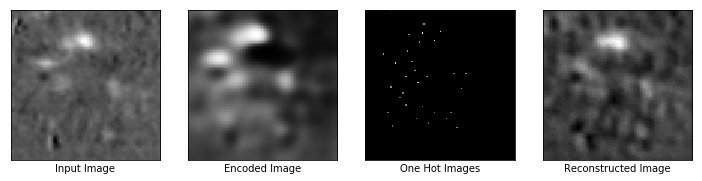

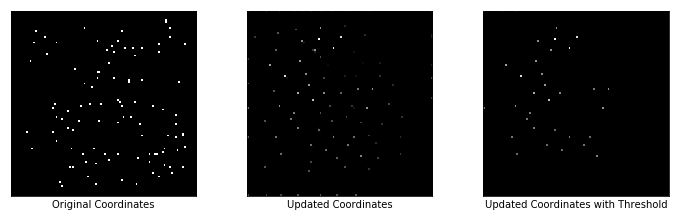

Epochs: 100, Session: 0
Reconstruction Loss: 0.0017339122714474797
Regularizer Loss: 1945.792724609375, Total Loss: 1945.79443359375
Encoder Loss: 4.437403678894043
Max Similarity scores: 0.780731201171875
Updated Coordinates: [[[0.5245136 0.8503928]]]
Gradient global min:-0.0011026865104213357, max:0.0008066763402894139
Gradient encoder min:-1.4996697902679443, max:1.5896306037902832
Gradient learnable coords min:-1.101486759580439e-05, max:4.419983724801568e-06



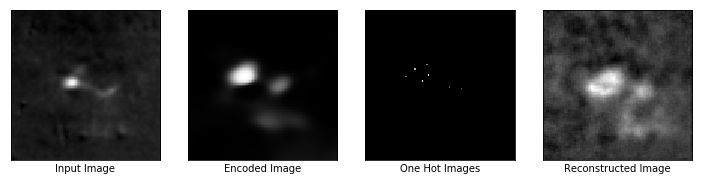

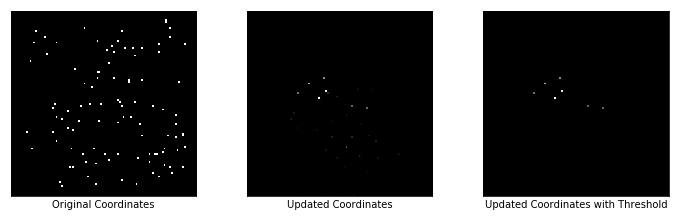

Epochs: 100, Session: 1
Reconstruction Loss: 0.001624568598344922
Regularizer Loss: 1568.224853515625, Total Loss: 1568.2264404296875
Encoder Loss: 0.9254075884819031
Max Similarity scores: 0.9134664535522461
Updated Coordinates: [[[0.52655447 0.8469651 ]]]
Gradient global min:-0.00013548703282140195, max:0.0004117836360819638
Gradient encoder min:-1.823275089263916, max:1.0246208906173706
Gradient learnable coords min:-1.858357063611038e-05, max:1.3911506357544567e-05



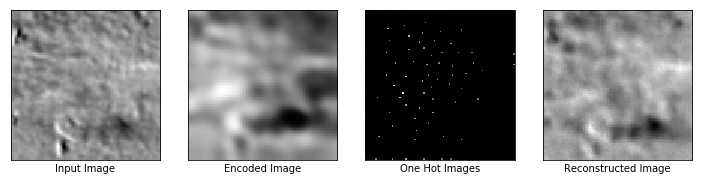

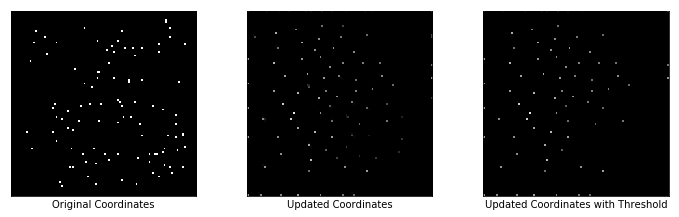

Epochs: 100, Session: 2
Reconstruction Loss: 0.002813378581777215
Regularizer Loss: 2453.751220703125, Total Loss: 2453.754150390625
Encoder Loss: 7.489901065826416
Max Similarity scores: 0.8685595989227295
Updated Coordinates: [[[0.52604604 0.8480428 ]]]
Gradient global min:-0.0013339247088879347, max:0.0022153276950120926
Gradient encoder min:-1.861404299736023, max:2.579486131668091
Gradient learnable coords min:-2.8908705189678585e-06, max:5.67083907299093e-06



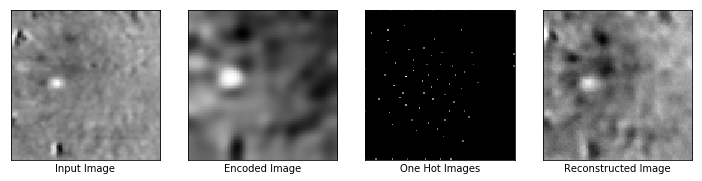

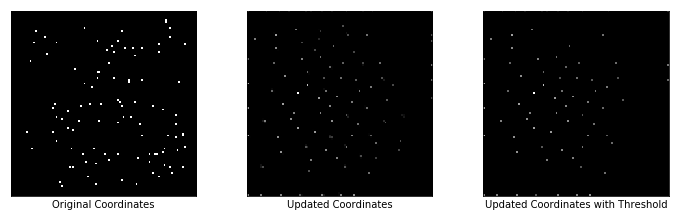

Epochs: 100, Session: 3
Reconstruction Loss: 0.0014077461091801524
Regularizer Loss: 2107.77734375, Total Loss: 2107.77880859375
Encoder Loss: 5.841702938079834
Max Similarity scores: 0.9598252773284912
Updated Coordinates: [[[0.5275723 0.8457508]]]
Gradient global min:-0.0006997293676249683, max:0.0010640242835506797
Gradient encoder min:-1.6100696325302124, max:2.0708227157592773
Gradient learnable coords min:-9.377599781146273e-06, max:4.0621921471029054e-06



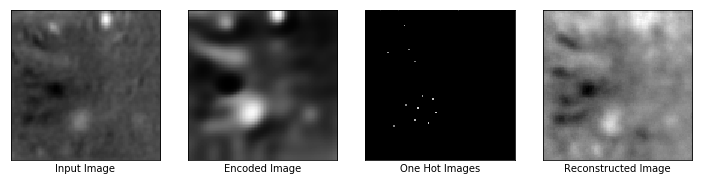

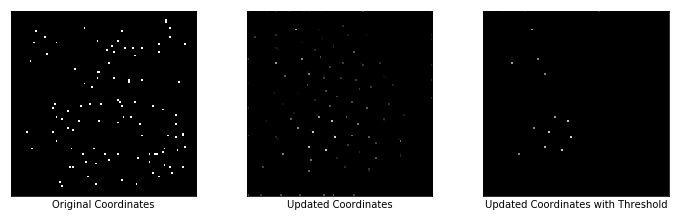

Epochs: 100, Session: 4
Reconstruction Loss: 0.0015639628982171416
Regularizer Loss: 1838.531982421875, Total Loss: 1838.5335693359375
Encoder Loss: 3.7911036014556885
Max Similarity scores: 0.6060477495193481
Updated Coordinates: [[[0.525904   0.85101575]]]
Gradient global min:-0.0015007930342108011, max:0.001576883252710104
Gradient encoder min:-1.5517456531524658, max:1.5536915063858032
Gradient learnable coords min:-1.4583840311388485e-05, max:6.170627602841705e-05



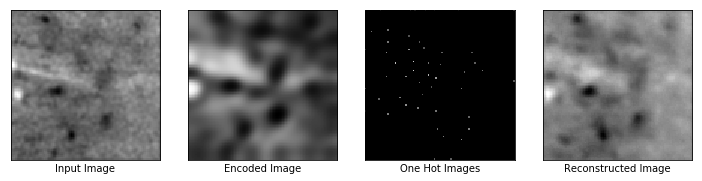

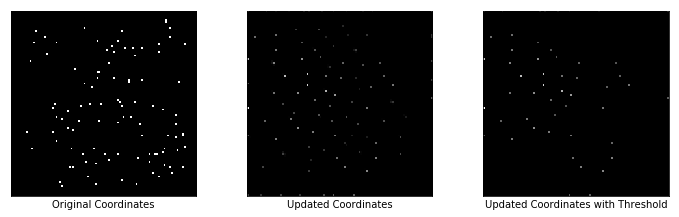

Epochs: 100, Session: 5
Reconstruction Loss: 0.002189314691349864
Regularizer Loss: 2356.777099609375, Total Loss: 2356.779296875
Encoder Loss: 6.751022815704346
Max Similarity scores: 0.9499316811561584
Updated Coordinates: [[[0.52575934 0.85005075]]]
Gradient global min:-0.0007552268216386437, max:0.0014441621024161577
Gradient encoder min:-1.8457894325256348, max:2.5011754035949707
Gradient learnable coords min:-1.4654990991402883e-05, max:8.244416676461697e-06



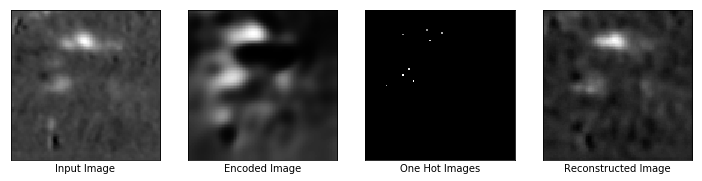

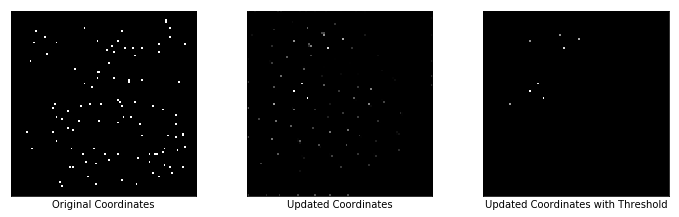

Epochs: 200, Session: 0
Reconstruction Loss: 0.0013288387563079596
Regularizer Loss: 2384.585693359375, Total Loss: 2384.5869140625
Encoder Loss: 3.6288957595825195
Max Similarity scores: 0.6513409614562988
Updated Coordinates: [[[0.5033579 0.848774 ]]]
Gradient global min:-0.0007671603234484792, max:0.0006699469522573054
Gradient encoder min:-1.5883930921554565, max:1.3854707479476929
Gradient learnable coords min:-1.4916902728145942e-05, max:5.360302020562813e-05



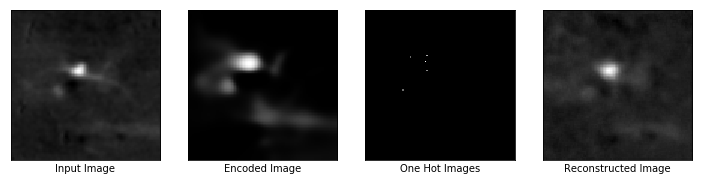

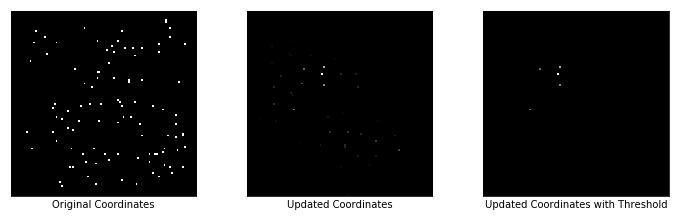

Epochs: 200, Session: 1
Reconstruction Loss: 0.0010133356554433703
Regularizer Loss: 2090.111572265625, Total Loss: 2090.112548828125
Encoder Loss: 0.8761671185493469
Max Similarity scores: 0.8299359083175659
Updated Coordinates: [[[0.50467986 0.84931576]]]
Gradient global min:-0.0001724465109873563, max:0.00016020052134990692
Gradient encoder min:-2.7672171592712402, max:1.1939209699630737
Gradient learnable coords min:-3.4761194456223166e-06, max:3.864875907311216e-06



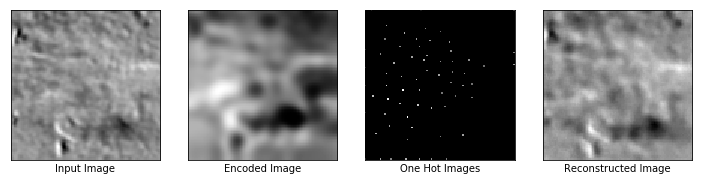

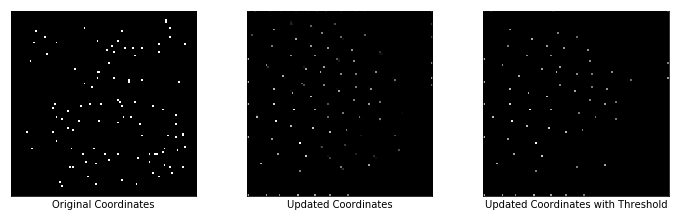

Epochs: 200, Session: 2
Reconstruction Loss: 0.002038051141425967
Regularizer Loss: 2860.51904296875, Total Loss: 2860.52099609375
Encoder Loss: 5.879124641418457
Max Similarity scores: 0.7561057209968567
Updated Coordinates: [[[0.50988925 0.85503316]]]
Gradient global min:-0.0008678584708832204, max:0.0004109047004021704
Gradient encoder min:-1.4172505140304565, max:2.314375162124634
Gradient learnable coords min:-9.76730643742485e-06, max:1.2730608432320878e-05



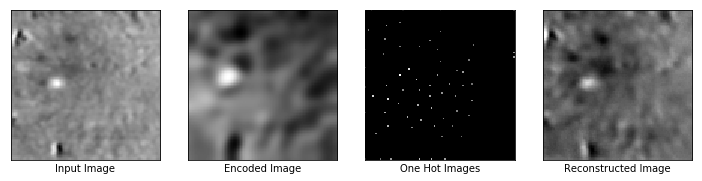

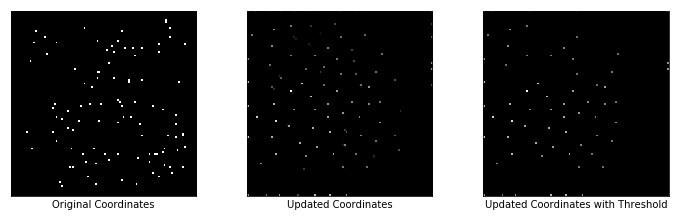

Epochs: 200, Session: 3
Reconstruction Loss: 0.0010736917611211538
Regularizer Loss: 2499.77001953125, Total Loss: 2499.77099609375
Encoder Loss: 4.744377613067627
Max Similarity scores: 0.7987217903137207
Updated Coordinates: [[[0.51574594 0.8463088 ]]]
Gradient global min:-0.0008679486927576363, max:0.0009184898226521909
Gradient encoder min:-1.495221495628357, max:1.7830449342727661
Gradient learnable coords min:-2.456128095218446e-05, max:8.690329195815139e-06



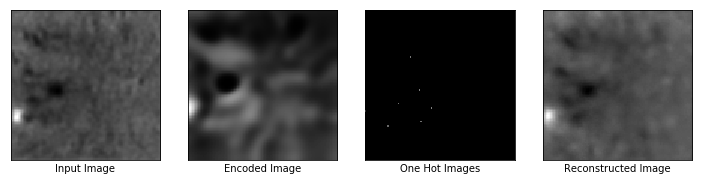

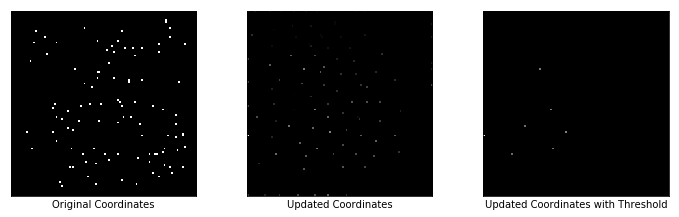

Epochs: 200, Session: 4
Reconstruction Loss: 0.0013756542466580868
Regularizer Loss: 2259.880615234375, Total Loss: 2259.882080078125
Encoder Loss: 3.122211217880249
Max Similarity scores: 0.747584879398346
Updated Coordinates: [[[0.51312983 0.847101  ]]]
Gradient global min:-0.002047901274636388, max:0.0017799928318709135
Gradient encoder min:-1.646247386932373, max:1.1943328380584717
Gradient learnable coords min:-5.949360911472468e-06, max:1.771838651620783e-05



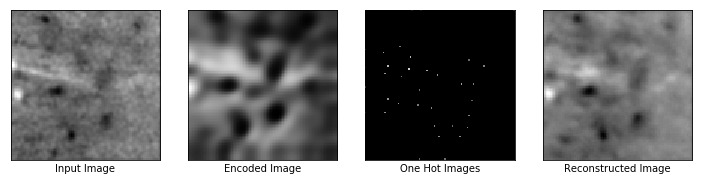

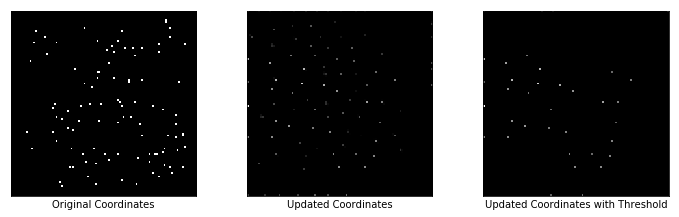

Epochs: 200, Session: 5
Reconstruction Loss: 0.002024144632741809
Regularizer Loss: 2772.2314453125, Total Loss: 2772.2333984375
Encoder Loss: 5.500667095184326
Max Similarity scores: 0.7994306683540344
Updated Coordinates: [[[0.49379495 0.84476924]]]
Gradient global min:-0.003826177679002285, max:0.005350923631340265
Gradient encoder min:-1.4380618333816528, max:2.056347370147705
Gradient learnable coords min:-4.3621072109090164e-05, max:4.370673923403956e-05



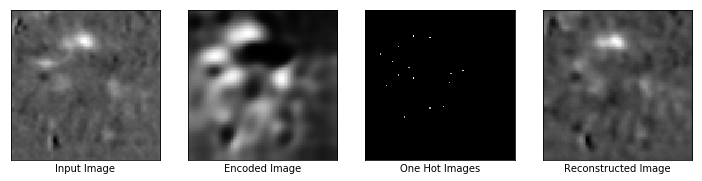

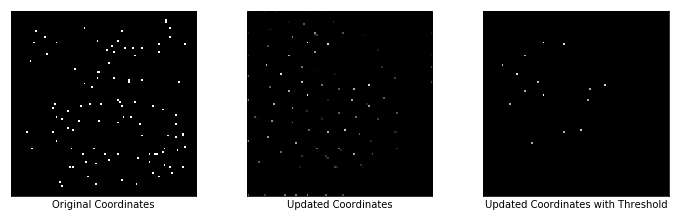

Epochs: 300, Session: 0
Reconstruction Loss: 0.0011200507869943976
Regularizer Loss: 2850.2470703125, Total Loss: 2850.248291015625
Encoder Loss: 2.7239415645599365
Max Similarity scores: 0.4811350405216217
Updated Coordinates: [[[0.47963947 0.8479953 ]]]
Gradient global min:-0.00037560617784038186, max:0.0005011493340134621
Gradient encoder min:-1.4546700716018677, max:1.1669621467590332
Gradient learnable coords min:-2.7366369977244176e-05, max:1.039127164403908e-05



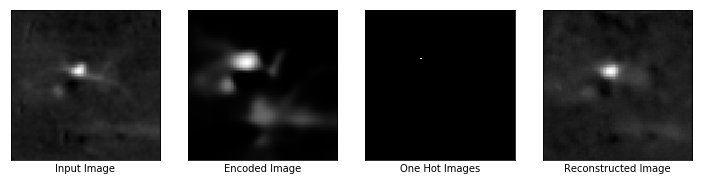

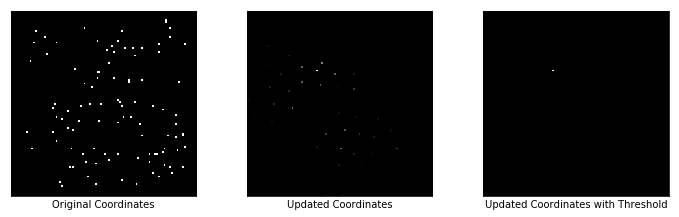

Epochs: 300, Session: 1
Reconstruction Loss: 0.0008026045979931951
Regularizer Loss: 2665.93017578125, Total Loss: 2665.930908203125
Encoder Loss: 0.7290393114089966
Max Similarity scores: 0.5853881239891052
Updated Coordinates: [[[0.4946945 0.84215  ]]]
Gradient global min:-0.0004073171876370907, max:0.00045314166345633566
Gradient encoder min:-2.397536516189575, max:0.9554922580718994
Gradient learnable coords min:-1.2421690371411387e-05, max:7.3345249802514445e-06



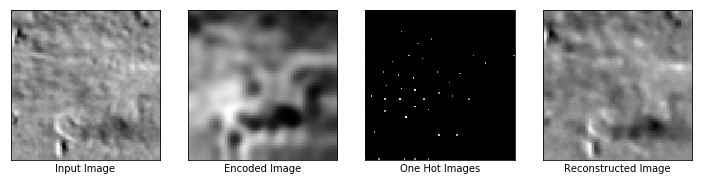

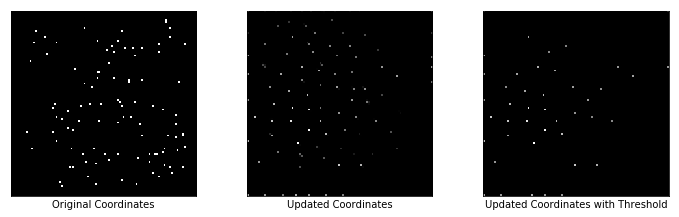

Epochs: 300, Session: 2
Reconstruction Loss: 0.0018196849850937724
Regularizer Loss: 3246.490234375, Total Loss: 3246.491943359375
Encoder Loss: 4.25096321105957
Max Similarity scores: 0.6044403314590454
Updated Coordinates: [[[0.4946218  0.83759886]]]
Gradient global min:-0.004524512216448784, max:0.00568578764796257
Gradient encoder min:-1.0138676166534424, max:2.190457344055176
Gradient learnable coords min:-8.570083082304336e-06, max:7.648443715879694e-05



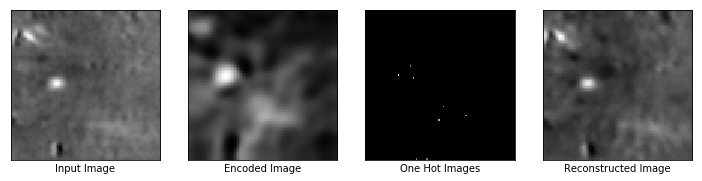

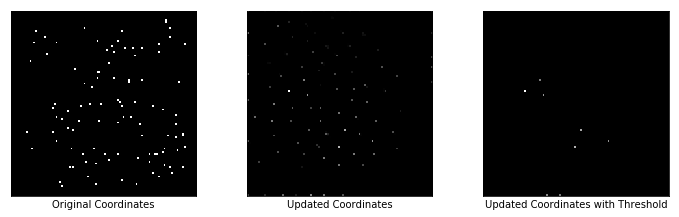

Epochs: 300, Session: 3
Reconstruction Loss: 0.0008958923281170428
Regularizer Loss: 2901.469970703125, Total Loss: 2901.470947265625
Encoder Loss: 3.526123046875
Max Similarity scores: 0.6330299973487854
Updated Coordinates: [[[0.4951474  0.83728737]]]
Gradient global min:-0.0002740391355473548, max:0.0004306085465941578
Gradient encoder min:-1.1176151037216187, max:1.672399878501892
Gradient learnable coords min:-8.59899228089489e-06, max:3.1454726467927685e-06



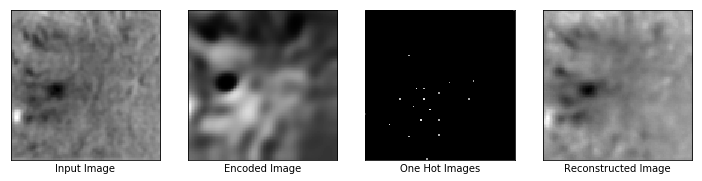

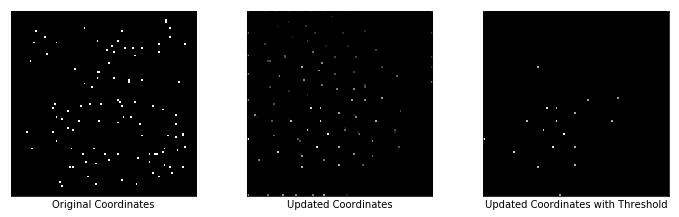

Epochs: 300, Session: 4
Reconstruction Loss: 0.001149528194218874
Regularizer Loss: 2724.554931640625, Total Loss: 2724.55615234375
Encoder Loss: 2.2566468715667725
Max Similarity scores: 0.485117107629776
Updated Coordinates: [[[0.4933028  0.83789384]]]
Gradient global min:-0.00038525921991094947, max:0.0002865201677195728
Gradient encoder min:-1.5348498821258545, max:0.9982125163078308
Gradient learnable coords min:-6.608450348721817e-05, max:4.3168522097403184e-05



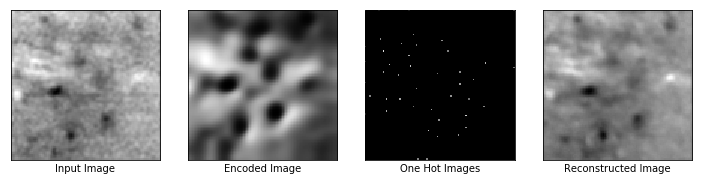

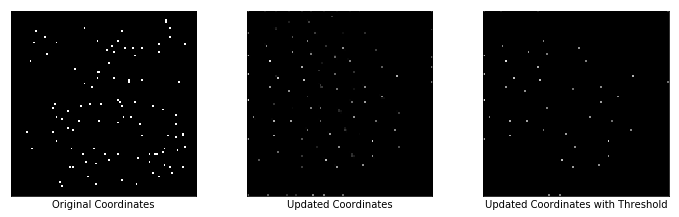

Epochs: 300, Session: 5
Reconstruction Loss: 0.001874421490356326
Regularizer Loss: 3149.156005859375, Total Loss: 3149.157958984375
Encoder Loss: 4.092380523681641
Max Similarity scores: 0.618404746055603
Updated Coordinates: [[[0.4839797  0.85049784]]]
Gradient global min:-0.004573574755340815, max:0.004676308948546648
Gradient encoder min:-1.1380420923233032, max:1.9092341661453247
Gradient learnable coords min:-2.5066932721529156e-05, max:4.3019674194511026e-05



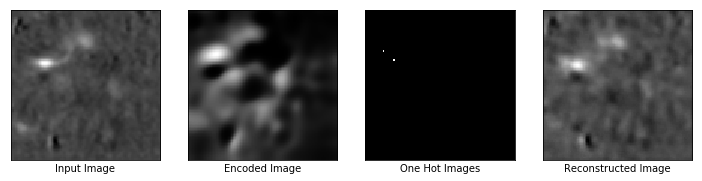

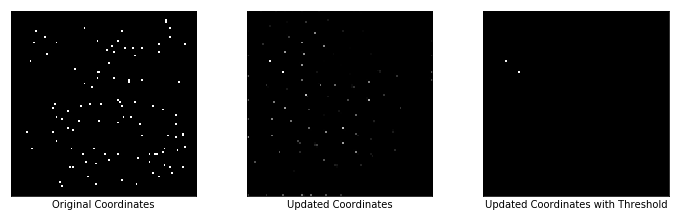

Epochs: 400, Session: 0
Reconstruction Loss: 0.0011370624415576458
Regularizer Loss: 4167.85595703125, Total Loss: 4167.85693359375
Encoder Loss: 2.028061628341675
Max Similarity scores: 0.3304724097251892
Updated Coordinates: [[[0.48015934 0.8392619 ]]]
Gradient global min:-0.002380959689617157, max:0.0032888806890696287
Gradient encoder min:-1.2242130041122437, max:0.7782368659973145
Gradient learnable coords min:-3.0300565413199365e-05, max:5.111370046506636e-05



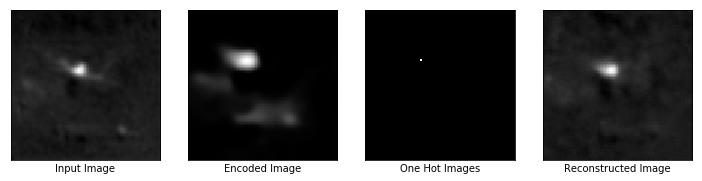

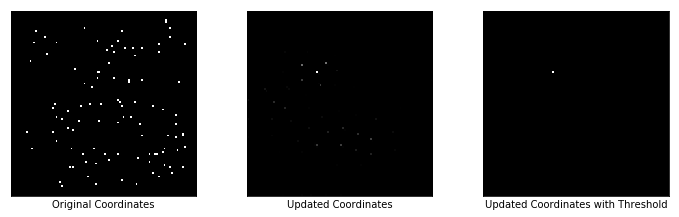

Epochs: 400, Session: 1
Reconstruction Loss: 0.0007906581158749759
Regularizer Loss: 3990.238525390625, Total Loss: 3990.2392578125
Encoder Loss: 0.5027430057525635
Max Similarity scores: 0.4873254895210266
Updated Coordinates: [[[0.48528975 0.83881193]]]
Gradient global min:-0.00066765007795766, max:0.0005223733023740351
Gradient encoder min:-1.516291856765747, max:0.717686653137207
Gradient learnable coords min:-1.996839273488149e-05, max:1.5093362890183926e-05



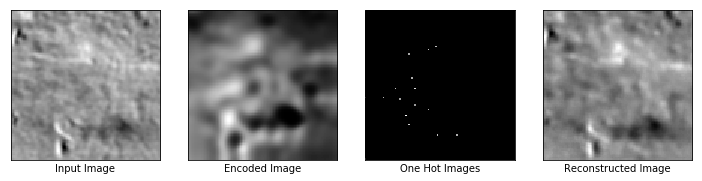

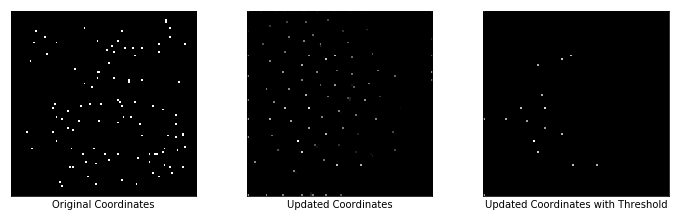

Epochs: 400, Session: 2
Reconstruction Loss: 0.0018651628633961082
Regularizer Loss: 4608.01904296875, Total Loss: 4608.02099609375
Encoder Loss: 3.1525025367736816
Max Similarity scores: 0.5103870630264282
Updated Coordinates: [[[0.48472136 0.8378661 ]]]
Gradient global min:-0.0035705515183508396, max:0.011674558743834496
Gradient encoder min:-0.9528161883354187, max:1.3920344114303589
Gradient learnable coords min:-6.906638736836612e-05, max:2.570706965343561e-05



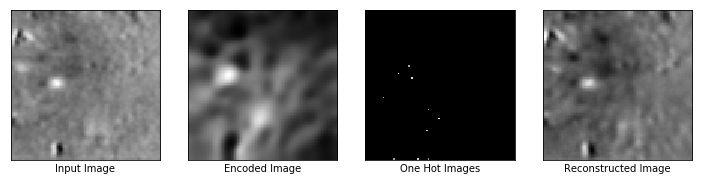

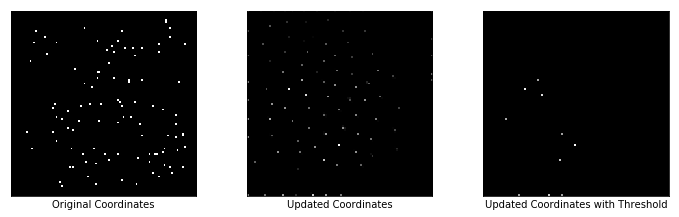

Epochs: 400, Session: 3
Reconstruction Loss: 0.0008072827477008104
Regularizer Loss: 4194.31396484375, Total Loss: 4194.31494140625
Encoder Loss: 2.579314947128296
Max Similarity scores: 0.4939141273498535
Updated Coordinates: [[[0.48550206 0.8371669 ]]]
Gradient global min:-0.000364961801096797, max:0.00039602137985639274
Gradient encoder min:-0.9164378046989441, max:1.0222318172454834
Gradient learnable coords min:-3.1132747153606033e-06, max:7.776049642416183e-06



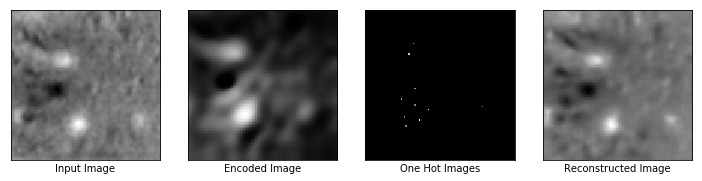

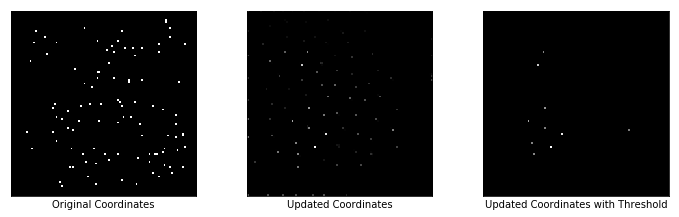

Epochs: 400, Session: 4
Reconstruction Loss: 0.0010169747984036803
Regularizer Loss: 4027.130859375, Total Loss: 4027.1318359375
Encoder Loss: 1.6223068237304688
Max Similarity scores: 0.6380091905593872
Updated Coordinates: [[[0.4841719  0.83762527]]]
Gradient global min:-0.0010320877190679312, max:0.0005610896041616797
Gradient encoder min:-1.1858577728271484, max:0.7042518854141235
Gradient learnable coords min:-1.9346234694239683e-05, max:2.7408639198256424e-06



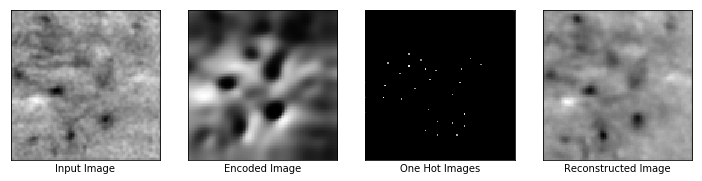

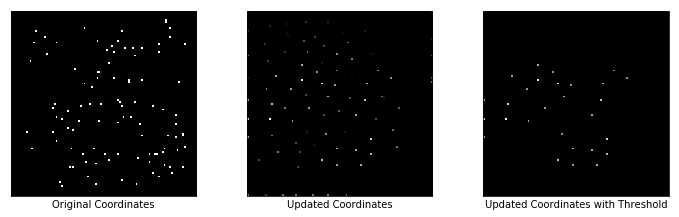

Epochs: 400, Session: 5
Reconstruction Loss: 0.0019648056477308273
Regularizer Loss: 4492.06982421875, Total Loss: 4492.07177734375
Encoder Loss: 3.080183744430542
Max Similarity scores: 0.5618682503700256
Updated Coordinates: [[[0.4849485 0.8357368]]]
Gradient global min:-0.0034189745783805847, max:0.002739865565672517
Gradient encoder min:-0.8793781399726868, max:1.2282006740570068
Gradient learnable coords min:-2.3710766981821507e-05, max:3.8198952097445726e-05



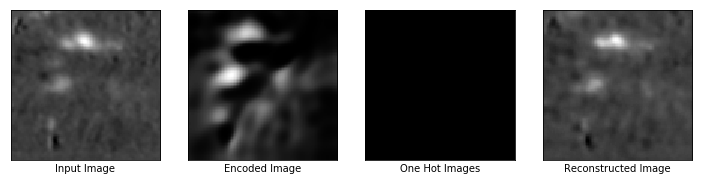

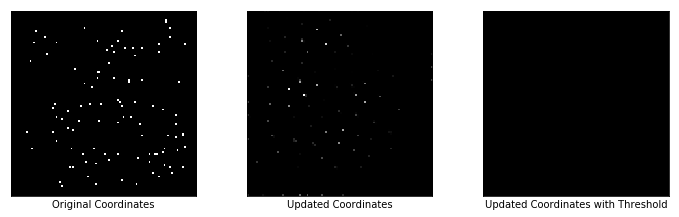

Epochs: 500, Session: 0
Reconstruction Loss: 0.0010624141432344913
Regularizer Loss: 6021.18505859375, Total Loss: 6021.18603515625
Encoder Loss: 1.5972589254379272
Max Similarity scores: 0.38802865147590637
Updated Coordinates: [[[0.4795022  0.84865236]]]
Gradient global min:-0.00414921622723341, max:0.003804862732067704
Gradient encoder min:-1.0656979084014893, max:0.7274260520935059
Gradient learnable coords min:-7.173875201260671e-05, max:0.00011720386100932956



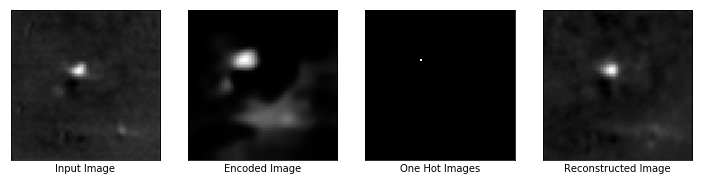

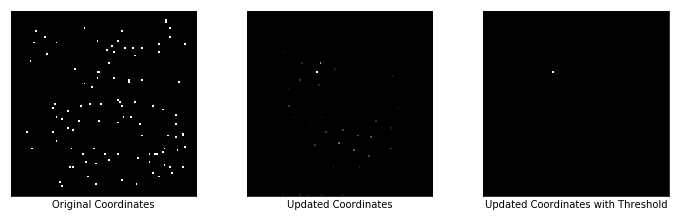

Epochs: 500, Session: 1
Reconstruction Loss: 0.0007983120158314705
Regularizer Loss: 5615.576171875, Total Loss: 5615.5771484375
Encoder Loss: 0.39109528064727783
Max Similarity scores: 0.3999461531639099
Updated Coordinates: [[[0.4645466  0.85059494]]]
Gradient global min:-0.00269814464263618, max:0.0005914228968322277
Gradient encoder min:-1.078098177909851, max:0.5466585159301758
Gradient learnable coords min:-7.717635526205413e-06, max:1.442006578145083e-05



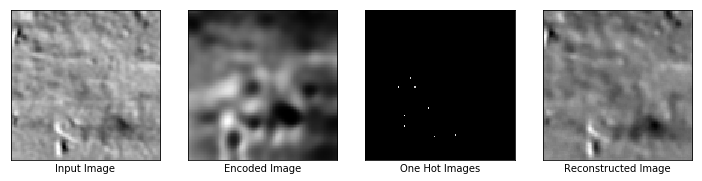

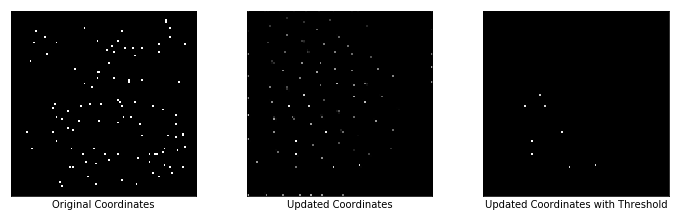

Epochs: 500, Session: 2
Reconstruction Loss: 0.001971358899027109
Regularizer Loss: 6726.78271484375, Total Loss: 6726.78466796875
Encoder Loss: 2.4693400859832764
Max Similarity scores: 0.3975473940372467
Updated Coordinates: [[[0.4654606 0.8495346]]]
Gradient global min:-0.007517220918089151, max:0.007464269176125526
Gradient encoder min:-0.7530891299247742, max:0.7753865718841553
Gradient learnable coords min:-3.2501138775842264e-05, max:5.164313915884122e-05



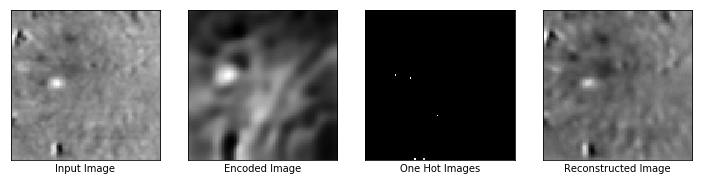

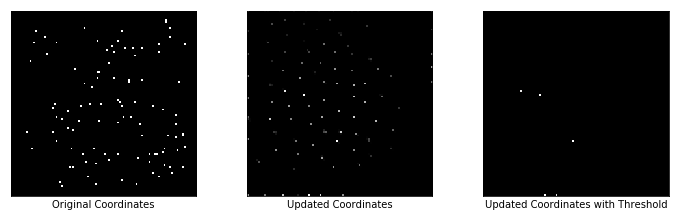

Epochs: 500, Session: 3
Reconstruction Loss: 0.0007709736819379032
Regularizer Loss: 6122.0712890625, Total Loss: 6122.072265625
Encoder Loss: 2.060187339782715
Max Similarity scores: 0.3822312653064728
Updated Coordinates: [[[0.46547243 0.8487865 ]]]
Gradient global min:-0.001962310168892145, max:0.0017445471603423357
Gradient encoder min:-0.8537202477455139, max:0.7714244723320007
Gradient learnable coords min:-9.528275768388994e-06, max:1.541485653433483e-05



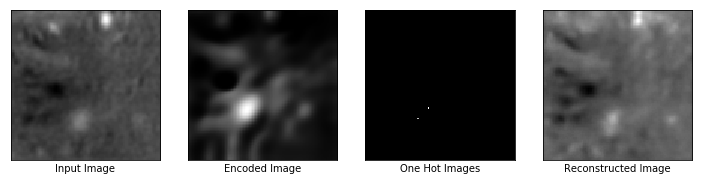

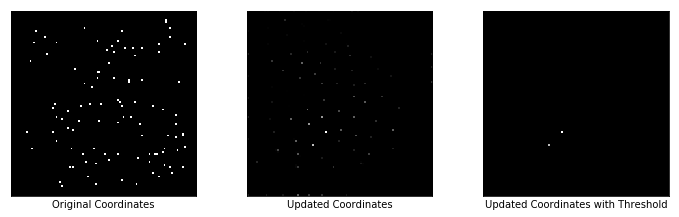

Epochs: 500, Session: 4
Reconstruction Loss: 0.001094613573513925
Regularizer Loss: 5840.4580078125, Total Loss: 5840.458984375
Encoder Loss: 1.350637674331665
Max Similarity scores: 0.41270145773887634
Updated Coordinates: [[[0.4652222 0.8482734]]]
Gradient global min:-0.0013950025895610452, max:0.0013619465753436089
Gradient encoder min:-1.0288286209106445, max:0.6741106510162354
Gradient learnable coords min:-1.2583744137373287e-05, max:1.7819151253206655e-05



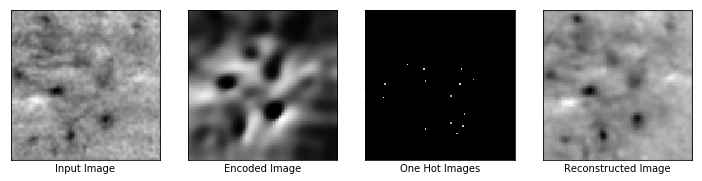

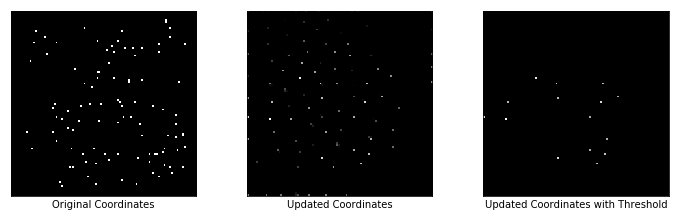

Epochs: 500, Session: 5
Reconstruction Loss: 0.0018366638105362654
Regularizer Loss: 6575.16162109375, Total Loss: 6575.16357421875
Encoder Loss: 2.46742582321167
Max Similarity scores: 0.455830454826355
Updated Coordinates: [[[0.46381602 0.84766924]]]
Gradient global min:-0.002361535793170333, max:0.0021950704976916313
Gradient encoder min:-0.6519680619239807, max:0.7691216468811035
Gradient learnable coords min:-6.836374086560681e-05, max:3.330412437207997e-05



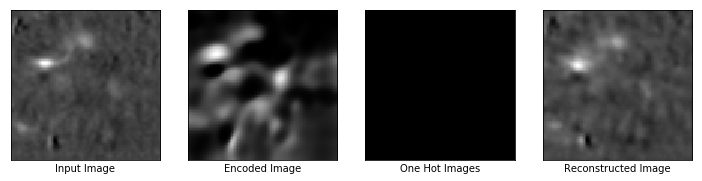

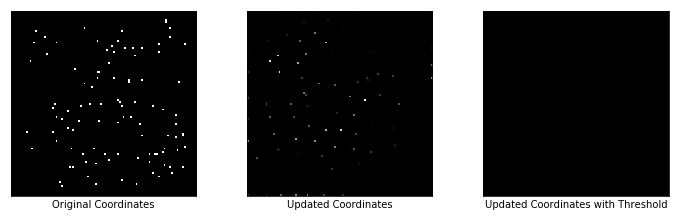

Epochs: 600, Session: 0
Reconstruction Loss: 0.001336231012828648
Regularizer Loss: 9319.0107421875, Total Loss: 9319.01171875
Encoder Loss: 1.4139525890350342
Max Similarity scores: 0.2224225252866745
Updated Coordinates: [[[0.45649198 0.85885304]]]
Gradient global min:-0.004485967569053173, max:0.003645534161478281
Gradient encoder min:-0.8079080581665039, max:0.6739914417266846
Gradient learnable coords min:-4.6498618758050725e-05, max:8.242241165135056e-05



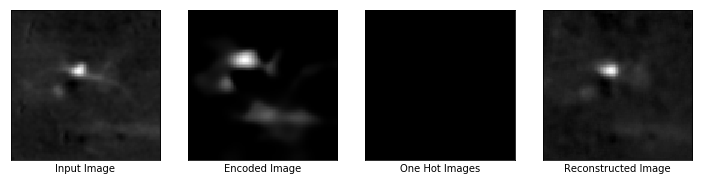

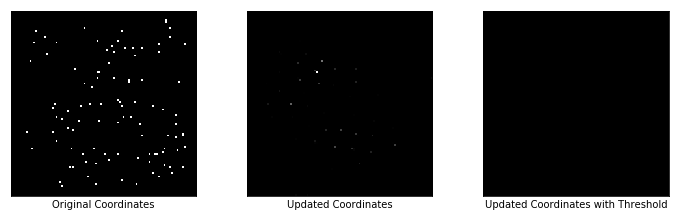

Epochs: 600, Session: 1
Reconstruction Loss: 0.000794015999417752
Regularizer Loss: 8535.4833984375, Total Loss: 8535.484375
Encoder Loss: 0.30687376856803894
Max Similarity scores: 0.364318311214447
Updated Coordinates: [[[0.45317408 0.8584768 ]]]
Gradient global min:-0.0001644645817577839, max:0.00038767853402532637
Gradient encoder min:-0.8302753567695618, max:0.577603280544281
Gradient learnable coords min:-1.6812309695524164e-05, max:3.5068398574367166e-05



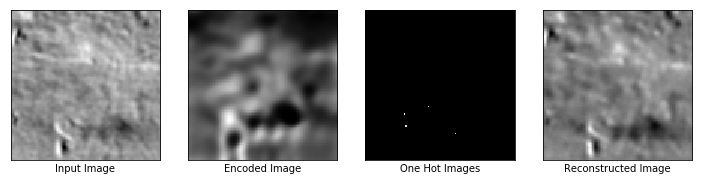

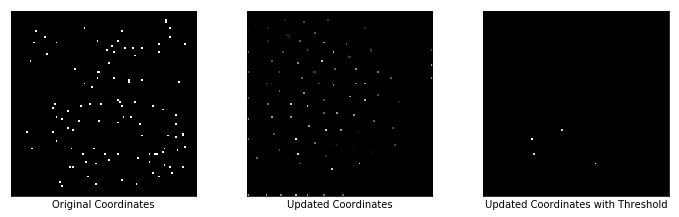

Epochs: 600, Session: 2
Reconstruction Loss: 0.0016771492082625628
Regularizer Loss: 10379.2197265625, Total Loss: 10379.2216796875
Encoder Loss: 2.180655002593994
Max Similarity scores: 0.3731950521469116
Updated Coordinates: [[[0.45486814 0.8578811 ]]]
Gradient global min:-0.0034340089187026024, max:0.007073916494846344
Gradient encoder min:-0.6008753776550293, max:0.5591297149658203
Gradient learnable coords min:-0.00012905066250823438, max:8.213763067033142e-05



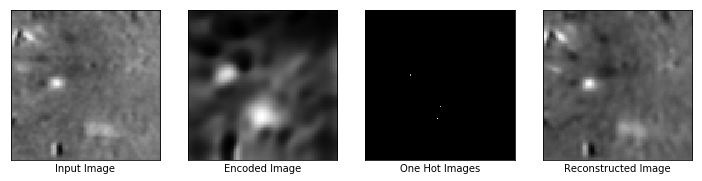

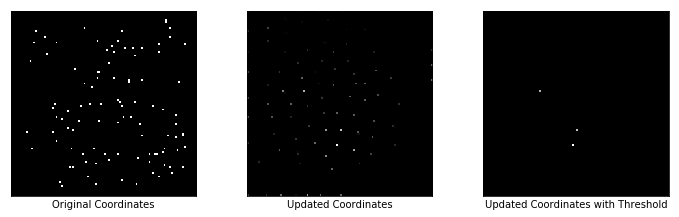

Epochs: 600, Session: 3
Reconstruction Loss: 0.0007251991773955524
Regularizer Loss: 9502.701171875, Total Loss: 9502.7021484375
Encoder Loss: 1.7611087560653687
Max Similarity scores: 0.4522329270839691
Updated Coordinates: [[[0.45402256 0.85777783]]]
Gradient global min:-0.0011639060685411096, max:0.0007347827777266502
Gradient encoder min:-0.6239106059074402, max:0.6476894021034241
Gradient learnable coords min:-7.993835424713325e-06, max:5.665672233590158e-06



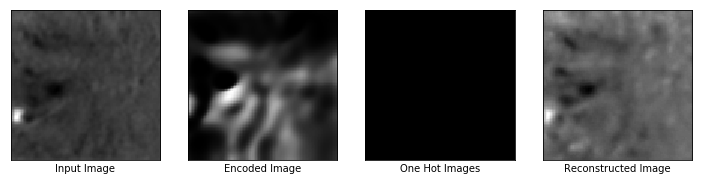

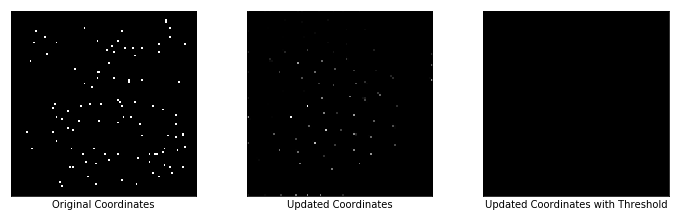

Epochs: 600, Session: 4
Reconstruction Loss: 0.0010199069511145353
Regularizer Loss: 9055.5419921875, Total Loss: 9055.54296875
Encoder Loss: 1.1541098356246948
Max Similarity scores: 0.15591111779212952
Updated Coordinates: [[[0.4538906 0.8578828]]]
Gradient global min:-0.0002940291306003928, max:0.0002546004834584892
Gradient encoder min:-0.7423813343048096, max:0.5515661835670471
Gradient learnable coords min:-1.5354653442045674e-05, max:1.2882009286840912e-05



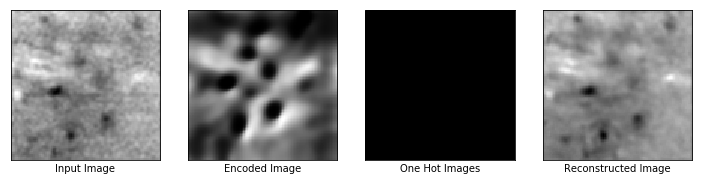

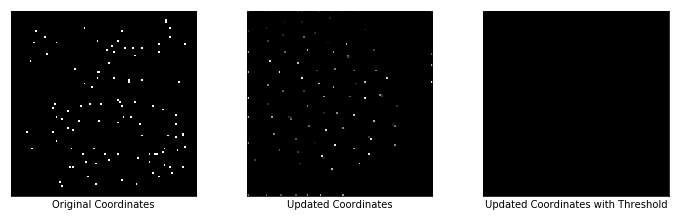

Epochs: 600, Session: 5
Reconstruction Loss: 0.0018648776458576322
Regularizer Loss: 10176.0419921875, Total Loss: 10176.0439453125
Encoder Loss: 2.1399483680725098
Max Similarity scores: 0.3629327416419983
Updated Coordinates: [[[0.45449176 0.85744196]]]
Gradient global min:-0.0036173993721604347, max:0.0030376992654055357
Gradient encoder min:-0.6000466346740723, max:0.597222626209259
Gradient learnable coords min:-3.0992025131126866e-05, max:1.4233756701287348e-05



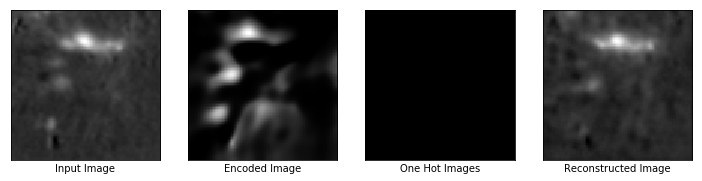

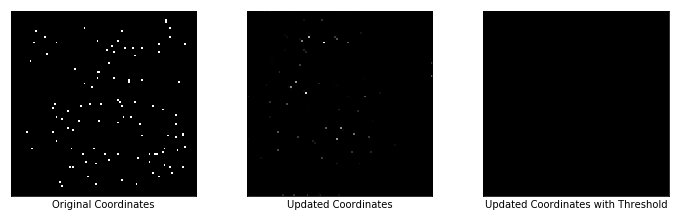

Epochs: 700, Session: 0
Reconstruction Loss: 0.000982059515081346
Regularizer Loss: 12409.0458984375, Total Loss: 12409.046875
Encoder Loss: 1.3396705389022827
Max Similarity scores: 0.24806351959705353
Updated Coordinates: [[[0.48767197 0.82733953]]]
Gradient global min:-0.0011760074412450194, max:0.0014100366970524192
Gradient encoder min:-0.8059450387954712, max:0.7899336218833923
Gradient learnable coords min:-5.449861055240035e-05, max:1.9162625903845765e-05



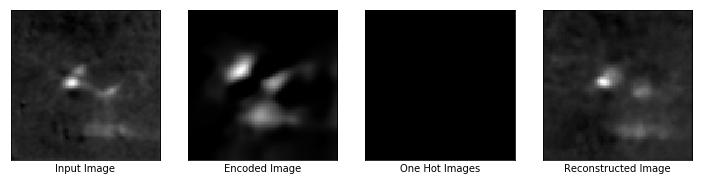

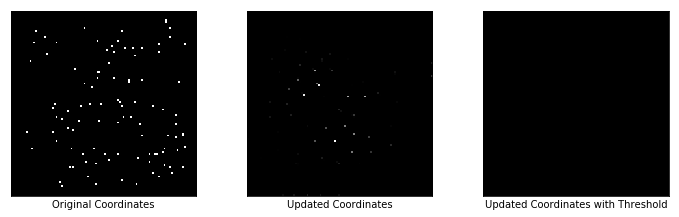

Epochs: 700, Session: 1
Reconstruction Loss: 0.0007671000785194337
Regularizer Loss: 11450.0927734375, Total Loss: 11450.09375
Encoder Loss: 0.3191942572593689
Max Similarity scores: 0.3663058578968048
Updated Coordinates: [[[0.49070564 0.8220947 ]]]
Gradient global min:-0.0071489992551505566, max:0.004157890100032091
Gradient encoder min:-0.8353936076164246, max:0.5992752909660339
Gradient learnable coords min:-4.454679583432153e-05, max:6.880428554723039e-05



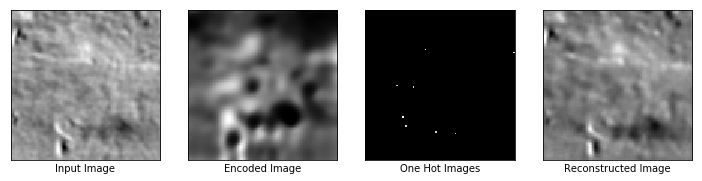

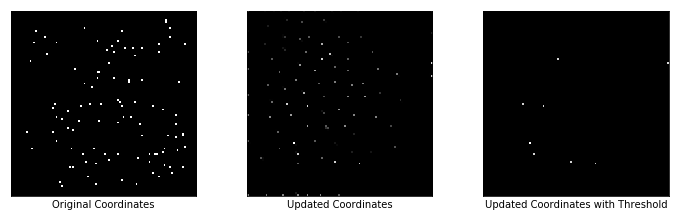

Epochs: 700, Session: 2
Reconstruction Loss: 0.0014289211248978972
Regularizer Loss: 13679.6689453125, Total Loss: 13679.669921875
Encoder Loss: 2.207766532897949
Max Similarity scores: 0.3924884498119354
Updated Coordinates: [[[0.47545037 0.8178477 ]]]
Gradient global min:-0.0037641371600329876, max:0.001611431478522718
Gradient encoder min:-0.5643323659896851, max:0.9088810086250305
Gradient learnable coords min:-1.6693882571416907e-05, max:2.5404679036000744e-05



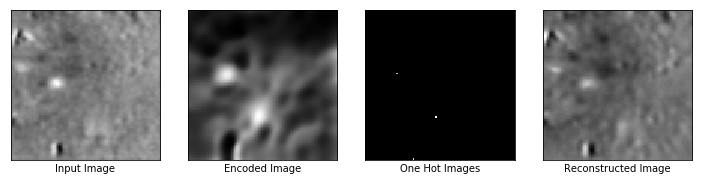

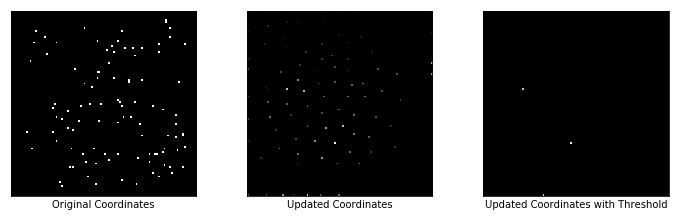

Epochs: 700, Session: 3
Reconstruction Loss: 0.001235386123880744
Regularizer Loss: 12611.1767578125, Total Loss: 12611.177734375
Encoder Loss: 1.5804983377456665
Max Similarity scores: 0.4193359613418579
Updated Coordinates: [[[0.48540574 0.8258272 ]]]
Gradient global min:-0.003951911348849535, max:0.004229160025715828
Gradient encoder min:-0.6082420349121094, max:0.7882072925567627
Gradient learnable coords min:-2.7988529836875387e-05, max:1.692991645541042e-05



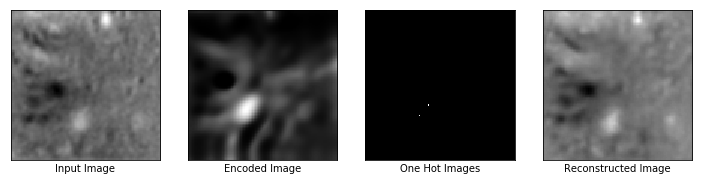

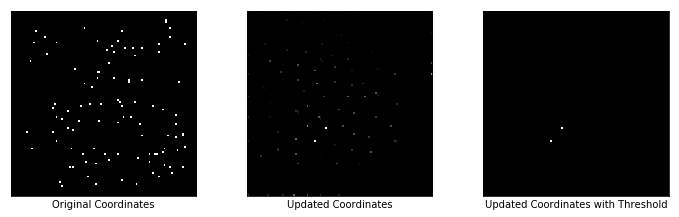

Epochs: 700, Session: 4
Reconstruction Loss: 0.0009675024193711579
Regularizer Loss: 12076.6953125, Total Loss: 12076.6962890625
Encoder Loss: 1.0878558158874512
Max Similarity scores: 0.4744325876235962
Updated Coordinates: [[[0.48448655 0.8290119 ]]]
Gradient global min:-0.0011435332708060741, max:0.0019968661945313215
Gradient encoder min:-0.7380629181861877, max:0.6638647317886353
Gradient learnable coords min:-2.790811959130224e-05, max:1.7797086911741644e-05



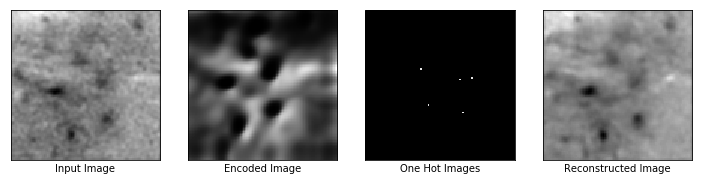

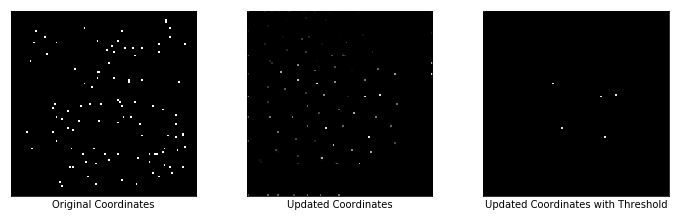

Epochs: 700, Session: 5
Reconstruction Loss: 0.0018027981277555227
Regularizer Loss: 13391.6689453125, Total Loss: 13391.6708984375
Encoder Loss: 2.033620595932007
Max Similarity scores: 0.3345157504081726
Updated Coordinates: [[[0.4811968  0.82881165]]]
Gradient global min:-0.008728956803679466, max:0.01655164174735546
Gradient encoder min:-0.5612671375274658, max:0.9040161371231079
Gradient learnable coords min:-2.3473574401577935e-05, max:8.920722393668257e-06



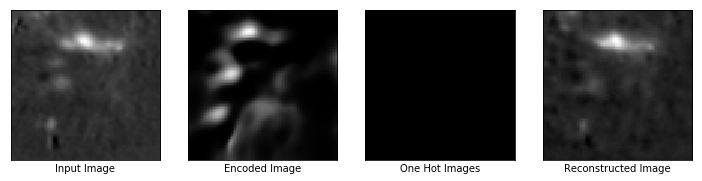

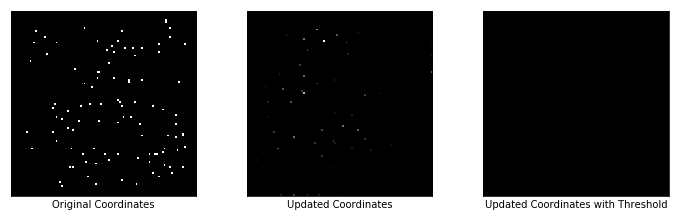

Epochs: 800, Session: 0
Reconstruction Loss: 0.0011281409533694386
Regularizer Loss: 15679.6494140625, Total Loss: 15679.650390625
Encoder Loss: 1.3750919103622437
Max Similarity scores: 0.2737674117088318
Updated Coordinates: [[[0.46287364 0.8502081 ]]]
Gradient global min:-0.002080613747239113, max:0.0025810461957007647
Gradient encoder min:-0.790532112121582, max:0.8525773286819458
Gradient learnable coords min:-1.6295605746563524e-05, max:2.143423625966534e-05



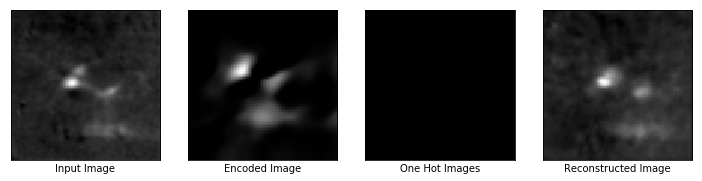

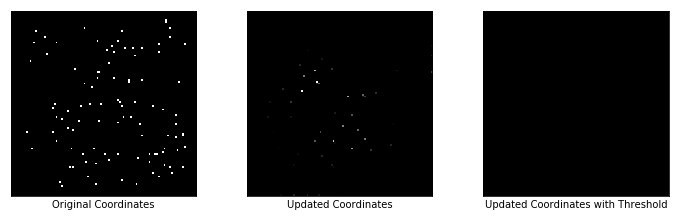

Epochs: 800, Session: 1
Reconstruction Loss: 0.0008639178122393787
Regularizer Loss: 14789.072265625, Total Loss: 14789.0732421875
Encoder Loss: 0.3154337406158447
Max Similarity scores: 0.4413911700248718
Updated Coordinates: [[[0.45887783 0.84016937]]]
Gradient global min:-0.011459166184067726, max:0.007915142923593521
Gradient encoder min:-0.8764558434486389, max:0.6413236856460571
Gradient learnable coords min:-5.6835811847122386e-05, max:9.804684850678314e-06



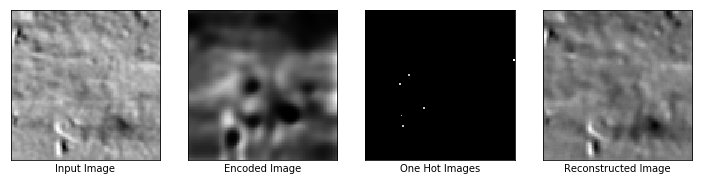

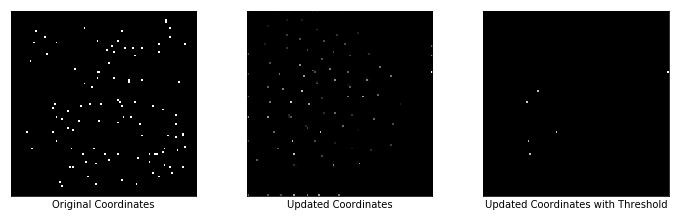

Epochs: 800, Session: 2
Reconstruction Loss: 0.0012035178951919079
Regularizer Loss: 16905.7421875, Total Loss: 16905.744140625
Encoder Loss: 2.188593626022339
Max Similarity scores: 0.43944743275642395
Updated Coordinates: [[[0.4656935 0.8429398]]]
Gradient global min:-0.001507569570094347, max:0.0012829573825001717
Gradient encoder min:-0.7573878169059753, max:1.351338267326355
Gradient learnable coords min:-2.9172930226195604e-05, max:1.1560373422980774e-05



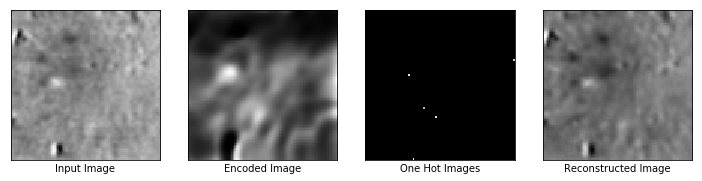

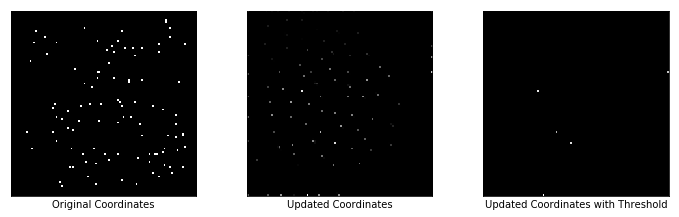

Epochs: 800, Session: 3
Reconstruction Loss: 0.0008341558277606964
Regularizer Loss: 15799.359375, Total Loss: 15799.3603515625
Encoder Loss: 1.6644752025604248
Max Similarity scores: 0.4303101599216461
Updated Coordinates: [[[0.46570066 0.8392908 ]]]
Gradient global min:-0.008981157094240189, max:0.004541484173387289
Gradient encoder min:-0.741238534450531, max:1.0649893283843994
Gradient learnable coords min:-5.26488429386518e-06, max:6.841316917416407e-06



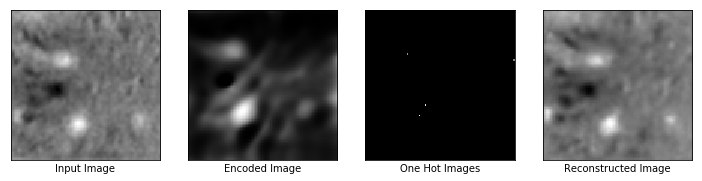

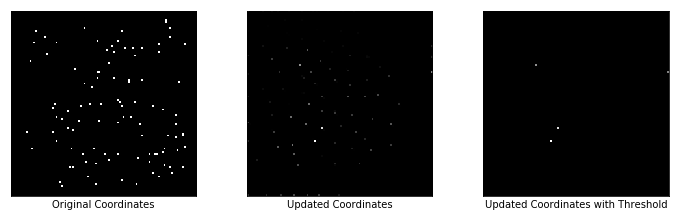

Epochs: 800, Session: 4
Reconstruction Loss: 0.0010754885151982307
Regularizer Loss: 15295.2568359375, Total Loss: 15295.2578125
Encoder Loss: 1.049617052078247
Max Similarity scores: 0.6027798056602478
Updated Coordinates: [[[0.47481722 0.8322835 ]]]
Gradient global min:-0.0013510460266843438, max:0.0013847212539985776
Gradient encoder min:-0.7224854230880737, max:0.6812864542007446
Gradient learnable coords min:-2.7484982638270594e-05, max:2.7397596568334848e-05



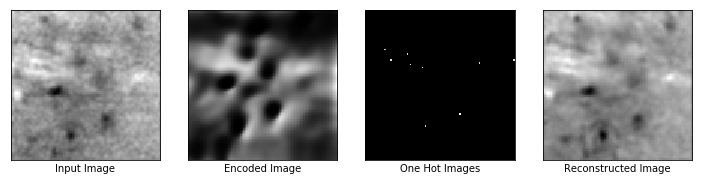

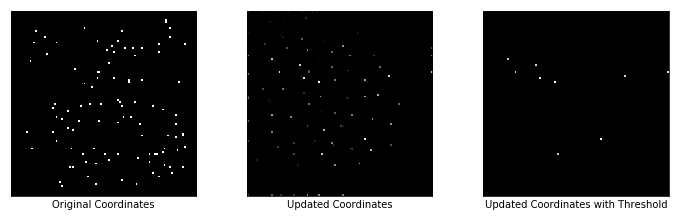

Epochs: 800, Session: 5
Reconstruction Loss: 0.0018762943800538778
Regularizer Loss: 16564.060546875, Total Loss: 16564.0625
Encoder Loss: 2.12333345413208
Max Similarity scores: 0.40048885345458984
Updated Coordinates: [[[0.47168118 0.83425385]]]
Gradient global min:-0.0008186742197722197, max:0.0013131689047440886
Gradient encoder min:-0.7868881225585938, max:1.3495349884033203
Gradient learnable coords min:-3.887687489623204e-05, max:5.923648495809175e-05



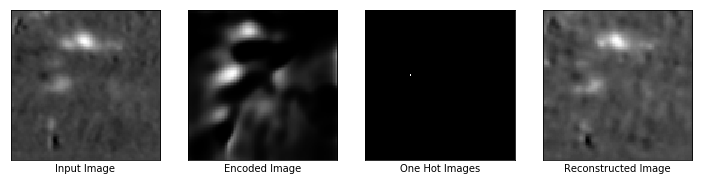

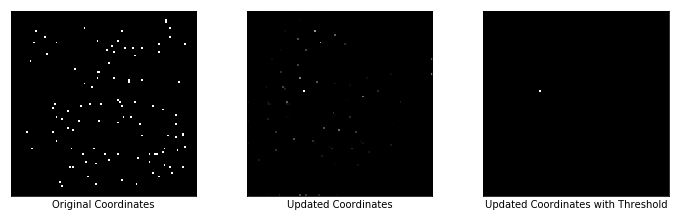

Epochs: 900, Session: 0
Reconstruction Loss: 0.0009739951929077506
Regularizer Loss: 16632.310546875, Total Loss: 16632.310546875
Encoder Loss: 1.5246102809906006
Max Similarity scores: 0.4224327504634857
Updated Coordinates: [[[0.47607145 0.8280005 ]]]
Gradient global min:-0.0012889564968645573, max:0.0016267523169517517
Gradient encoder min:-1.0737634897232056, max:0.8526325225830078
Gradient learnable coords min:-8.930697367759421e-05, max:4.068397174705751e-05



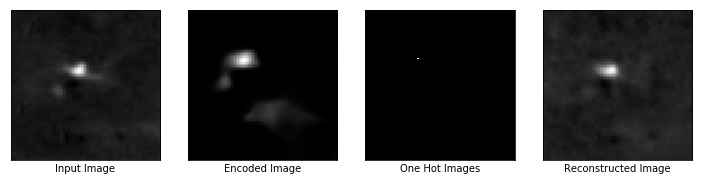

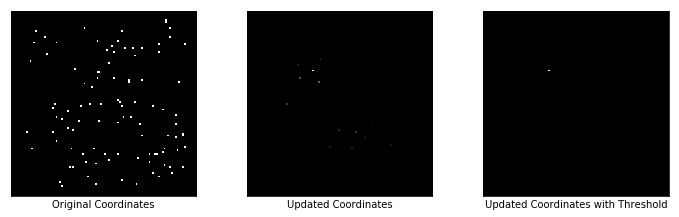

Epochs: 900, Session: 1
Reconstruction Loss: 0.0007498546037822962
Regularizer Loss: 16588.423828125, Total Loss: 16588.423828125
Encoder Loss: 0.284791499376297
Max Similarity scores: 0.35187768936157227
Updated Coordinates: [[[0.47568288 0.82727677]]]
Gradient global min:-0.00044171593617647886, max:0.000286910159047693
Gradient encoder min:-0.685512363910675, max:0.3959255516529083
Gradient learnable coords min:-1.9893514036084525e-05, max:1.1585181709961034e-05



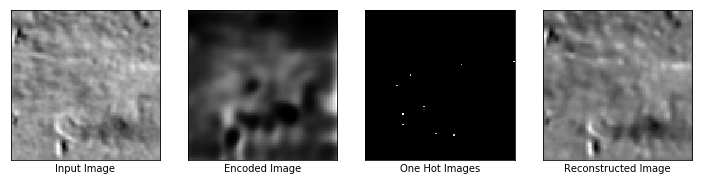

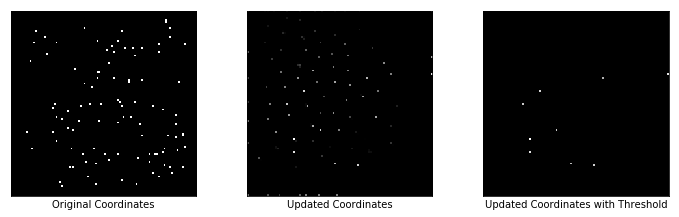

Epochs: 900, Session: 2
Reconstruction Loss: 0.0016421535983681679
Regularizer Loss: 17315.12109375, Total Loss: 17315.123046875
Encoder Loss: 2.5085034370422363
Max Similarity scores: 0.4909670054912567
Updated Coordinates: [[[0.47479165 0.82773846]]]
Gradient global min:-0.007996810600161552, max:0.008517563343048096
Gradient encoder min:-1.284518837928772, max:1.2823067903518677
Gradient learnable coords min:-2.251572732347995e-05, max:2.4899014533730224e-05



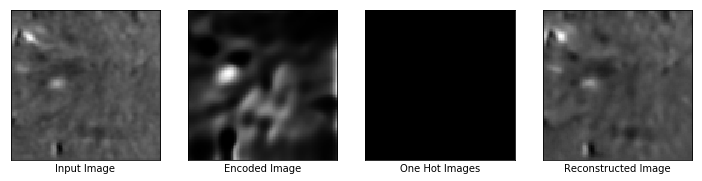

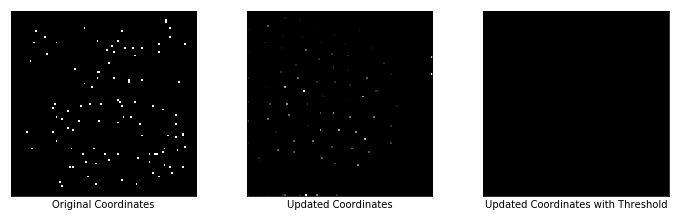

Epochs: 900, Session: 3
Reconstruction Loss: 0.0007309297216124833
Regularizer Loss: 16430.298828125, Total Loss: 16430.298828125
Encoder Loss: 1.9282950162887573
Max Similarity scores: 0.3051716685295105
Updated Coordinates: [[[0.4759727 0.8276496]]]
Gradient global min:-0.00030934790265746415, max:0.00033456983510404825
Gradient encoder min:-1.2730506658554077, max:1.122107744216919
Gradient learnable coords min:-3.377009488758631e-05, max:3.247691347496584e-05



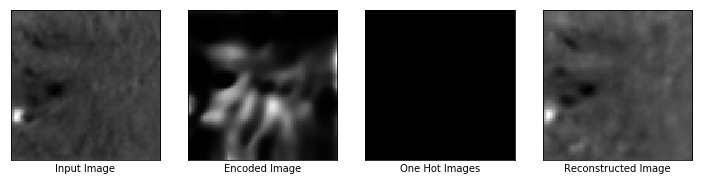

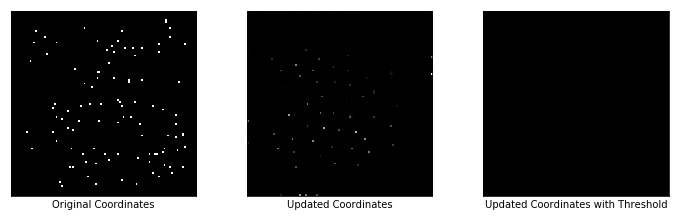

Epochs: 900, Session: 4
Reconstruction Loss: 0.0009875984396785498
Regularizer Loss: 16286.14453125, Total Loss: 16286.1455078125
Encoder Loss: 1.165056586265564
Max Similarity scores: 0.19249916076660156
Updated Coordinates: [[[0.47429523 0.82861334]]]
Gradient global min:-0.0004332537646405399, max:0.0010180302197113633
Gradient encoder min:-1.0182312726974487, max:0.729174017906189
Gradient learnable coords min:-1.0248262697132304e-05, max:7.559507139376365e-06



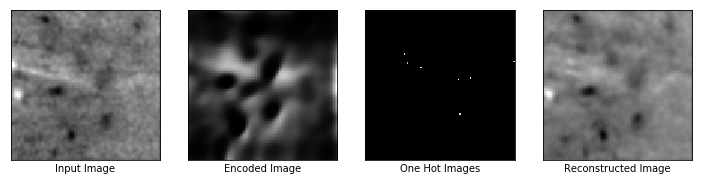

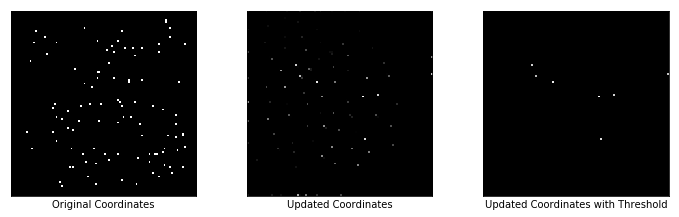

Epochs: 900, Session: 5
Reconstruction Loss: 0.00181979825720191
Regularizer Loss: 16954.109375, Total Loss: 16954.111328125
Encoder Loss: 2.5393097400665283
Max Similarity scores: 0.4344438910484314
Updated Coordinates: [[[0.47380513 0.8281384 ]]]
Gradient global min:-0.002536909421905875, max:0.0019560831133276224
Gradient encoder min:-1.4214463233947754, max:1.4291188716888428
Gradient learnable coords min:-1.971284109458793e-05, max:6.896834747749381e-06



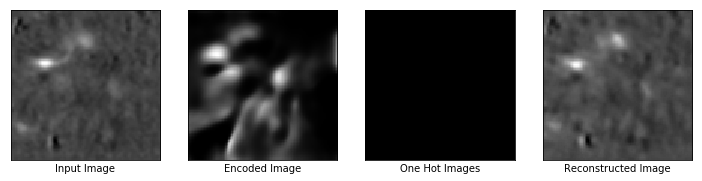

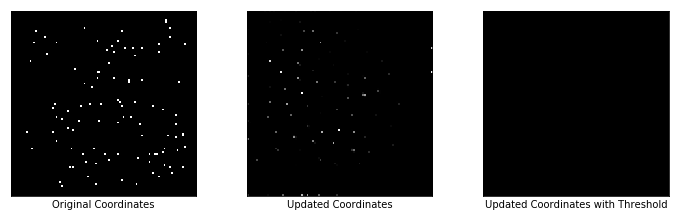

Epochs: 1000, Session: 0
Reconstruction Loss: 0.0008388098794966936
Regularizer Loss: 19611.984375, Total Loss: 19611.984375
Encoder Loss: 1.7199116945266724
Max Similarity scores: 0.2915041446685791
Updated Coordinates: [[[0.47853982 0.8302069 ]]]
Gradient global min:-0.000463292992208153, max:0.0007985372794792056
Gradient encoder min:-2.5015132427215576, max:1.9622275829315186
Gradient learnable coords min:-7.168415777414339e-06, max:2.613123615446966e-05



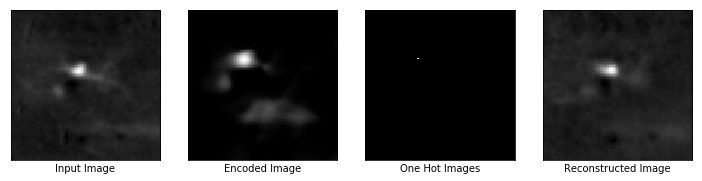

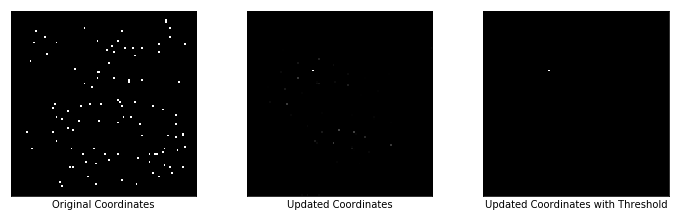

Epochs: 1000, Session: 1
Reconstruction Loss: 0.0007846308290027082
Regularizer Loss: 19720.92578125, Total Loss: 19720.92578125
Encoder Loss: 0.3367966413497925
Max Similarity scores: 0.4762559235095978
Updated Coordinates: [[[0.48399213 0.81671125]]]
Gradient global min:-0.0011423083487898111, max:0.0015979568706825376
Gradient encoder min:-0.9158117771148682, max:0.43602311611175537
Gradient learnable coords min:-5.8803543652174994e-05, max:0.00011535705561982468



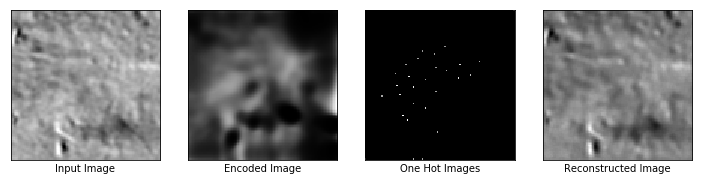

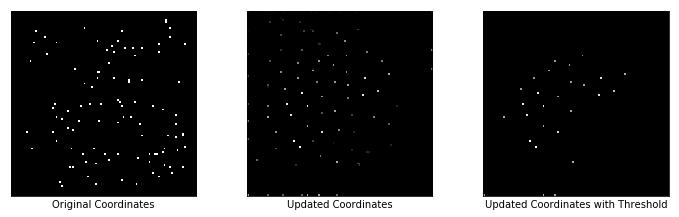

Epochs: 1000, Session: 2
Reconstruction Loss: 0.0012765814317390323
Regularizer Loss: 20338.818359375, Total Loss: 20338.8203125
Encoder Loss: 2.9991447925567627
Max Similarity scores: 0.548141598701477
Updated Coordinates: [[[0.48500985 0.81719726]]]
Gradient global min:-0.010032441467046738, max:0.010882665403187275
Gradient encoder min:-2.819561004638672, max:3.0996086597442627
Gradient learnable coords min:-1.9214654457755387e-05, max:1.334445823886199e-05



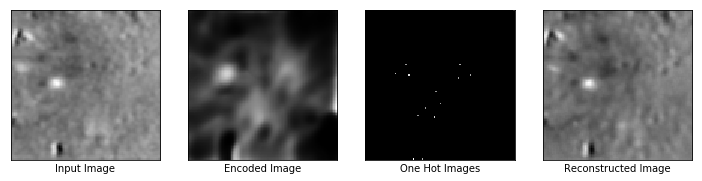

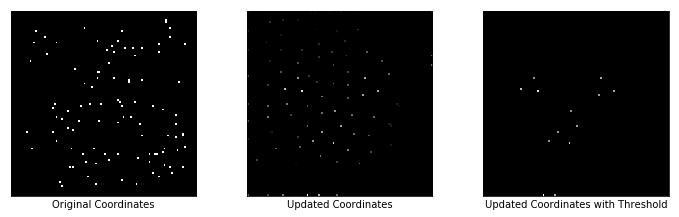

Epochs: 1000, Session: 3
Reconstruction Loss: 0.0009063122561201453
Regularizer Loss: 19427.1875, Total Loss: 19427.1875
Encoder Loss: 2.257117509841919
Max Similarity scores: 0.5925050377845764
Updated Coordinates: [[[0.48596022 0.8202157 ]]]
Gradient global min:-0.010558219626545906, max:0.008555121719837189
Gradient encoder min:-2.9610908031463623, max:2.6080846786499023
Gradient learnable coords min:-1.0814410416060127e-05, max:9.299894372816198e-06



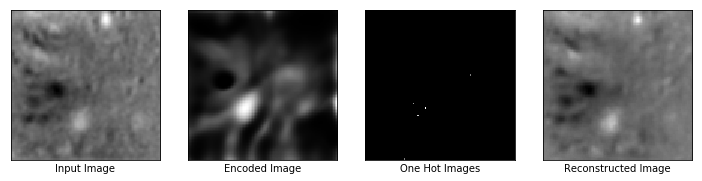

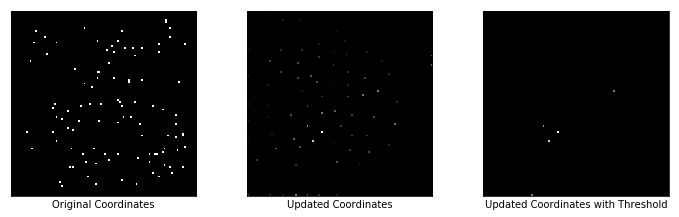

Epochs: 1000, Session: 4
Reconstruction Loss: 0.0010396767174825072
Regularizer Loss: 19255.806640625, Total Loss: 19255.80859375
Encoder Loss: 1.360611081123352
Max Similarity scores: 0.6385579109191895
Updated Coordinates: [[[0.4846689  0.81718475]]]
Gradient global min:-0.0025926006492227316, max:0.00163730897475034
Gradient encoder min:-2.3806960582733154, max:1.822031855583191
Gradient learnable coords min:-9.180042980005965e-06, max:4.718173386208946e-06



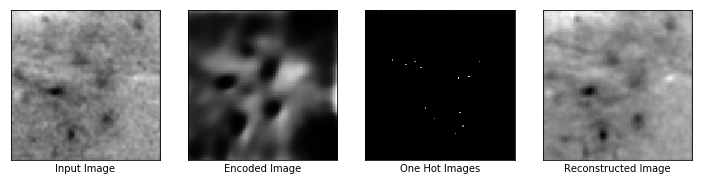

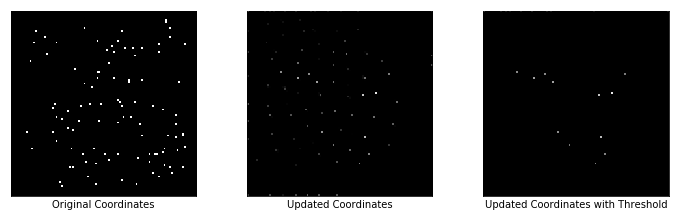

Epochs: 1000, Session: 5
Reconstruction Loss: 0.0018464191816747189
Regularizer Loss: 20015.236328125, Total Loss: 20015.23828125
Encoder Loss: 2.8259687423706055
Max Similarity scores: 0.6128178238868713
Updated Coordinates: [[[0.48338652 0.8159551 ]]]
Gradient global min:-0.0038700299337506294, max:0.009739723056554794
Gradient encoder min:-2.6851067543029785, max:3.1043176651000977
Gradient learnable coords min:-3.767145608435385e-05, max:2.396654963376932e-05


In [12]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    sess = 0
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        #loss for each session
        loss_sess = [] #reconstruction loss
        reg_loss_sess = [] #regularizer loss
        enc_loss_sess = [] #ecnoder loss
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
#                 encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
#                 reconstruction_last_sess.append(reconstruction)
        
        #append all sessions for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
#             encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
#             reconstruction_last_list.append(reconstruction_last_sess)


        if epochs%100==0:
            rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
            img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
            img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
            plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
            plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
            #print for each session in the epochs 
            #note for loss indices
            #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
            print("Epochs: {}, Session: {}".format(epochs, sess))
            print("Reconstruction Loss: {}".format(loss[0].numpy()))
            print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
            print("Encoder Loss: {}".format(loss[1].numpy()))
            print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
            print("Updated Coordinates: {}".format(updated_coords[0]))
            print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
            print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
            print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
            #append to list 
            encoded_imgs.append(encoder_output)
            input_imgs.append(batched_imgs)
            coords_list.append(updated_coords)
            reconstructed_imgs.append(reconstruction)
            one_hot_imgs_list.append(one_hot_imgs)
            similarity_list.append(similarity_score)
        
        sess+=1
        #append all losses for each session
        loss_sess.append(loss[0])
        reg_loss_sess.append(loss[1])
        enc_loss_sess.append(loss[-1])
    #loss is append for each epochs
    loss_list_global.append(np.mean(np.array(loss_sess)))
    loss_list_encoded_one_hot.append(np.mean(np.array(reg_loss_sess)))
    regulariser_loss_list.append(np.mean(np.array(enc_loss_sess)))
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
store_name = [d.split(".")[0] for d in sorted(os.listdir(ds_dir))]
#intended save path 
int_save_path = path_desktop+'npy/{}/sim_one_{}'.format(ver, ver)
#create new file to store sim score and one hot images for last frames
if not os.path.exists(int_save_path):
    os.makedirs(int_save_path)

#save sim scores for every session in last epochs 
similarity_score_last_list = utils.concat_batch(similarity_score_last_list) #(sess, frames, n_neurons)
for idx, stack in enumerate(similarity_score_last_list):
    np.save(int_save_path+'/sim_last_{}_{}.npy'.format(store_name[idx], ver), np.array(stack))

In [16]:
#save one hot imgs for last epochs 
for idx,stack in enumerate(one_hot_imgs_last_list):
    tensor = tf.convert_to_tensor(stack, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
    np.save(int_save_path+'/one_last_{}_{}.npy'.format(store_name[idx], ver), np.array(tensor))

In [38]:
# #save info for every frames in last epochs
# save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
# save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

# for names, items in zip(save_names_last, save_list_last):
#     aggregate_tensor = utils.concat_batch(items)
#     np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [47]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [ ]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [19]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [20]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

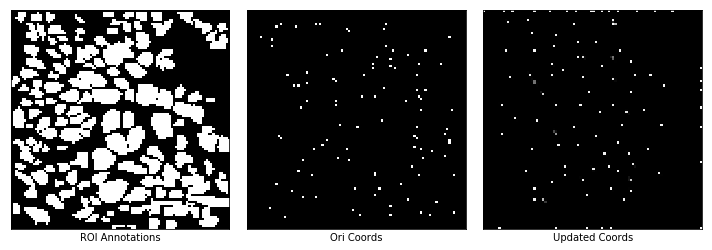

In [21]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  108


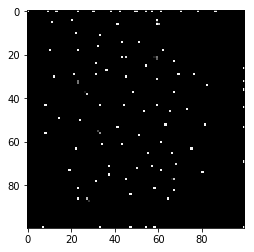

In [22]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

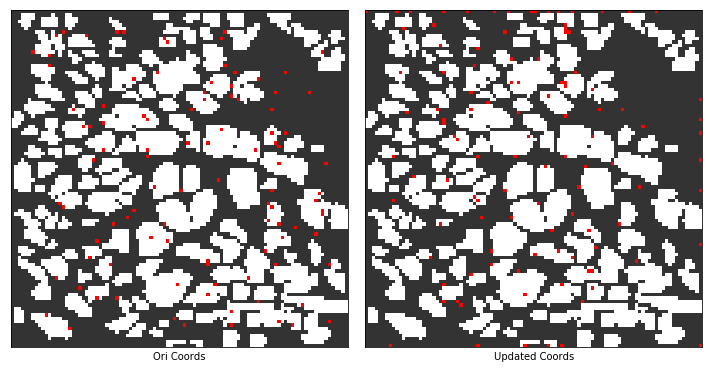

In [23]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [25]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

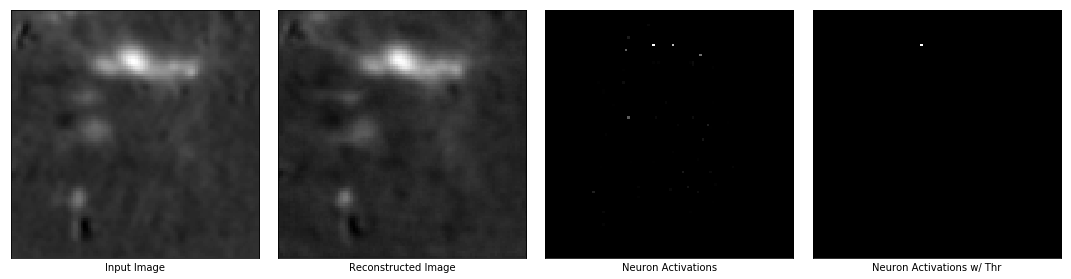

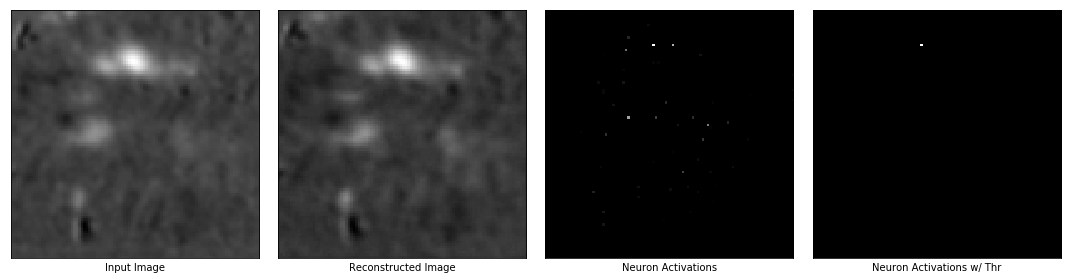

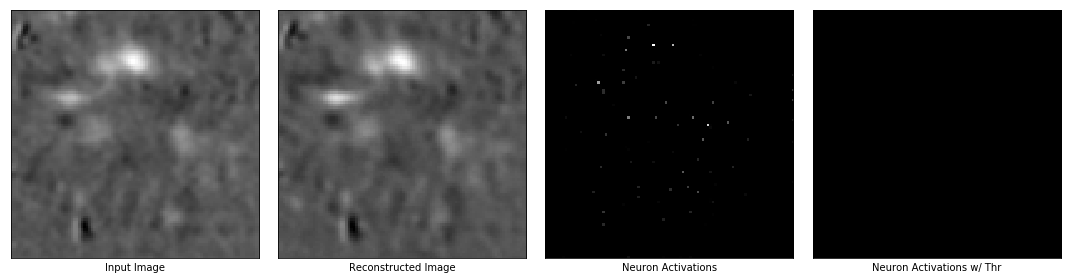

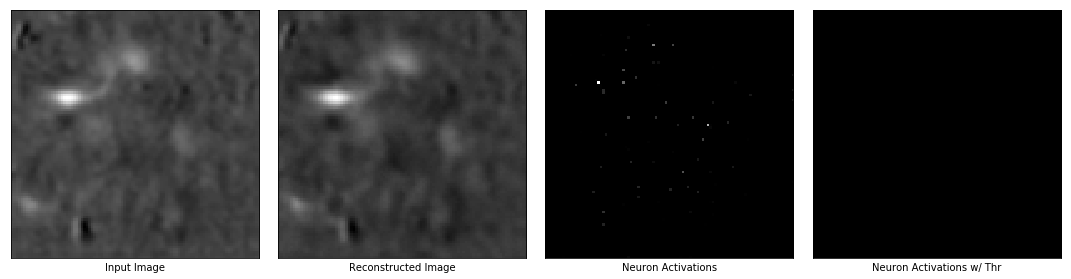

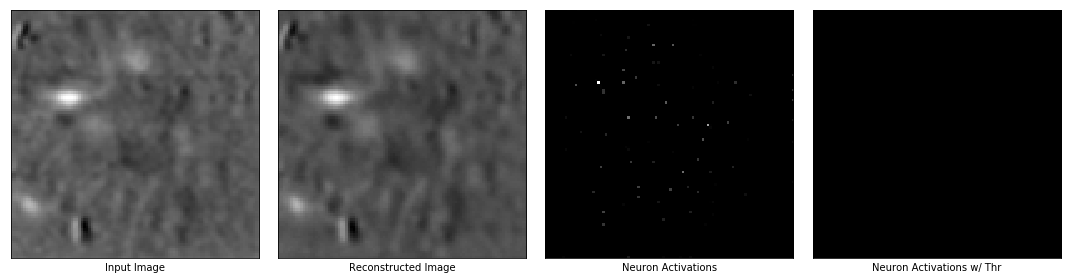

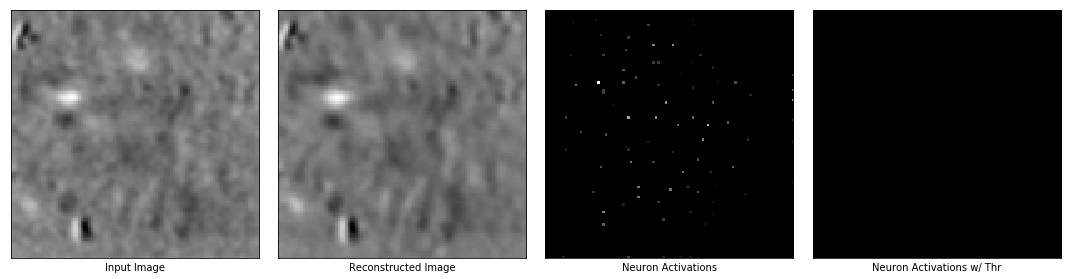

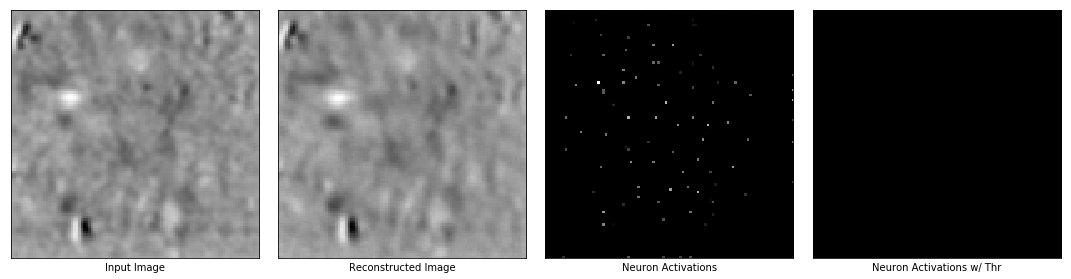

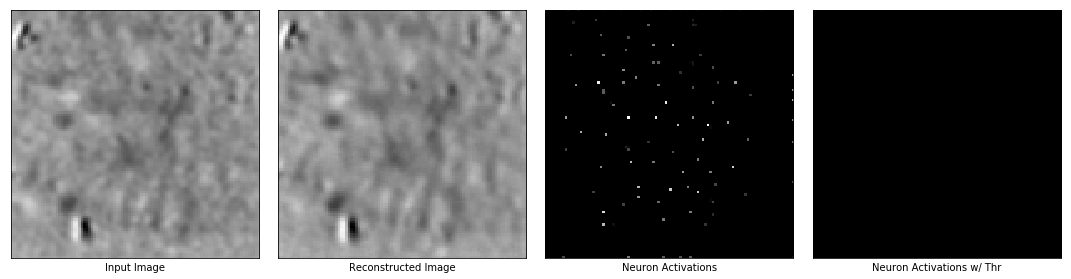

In [26]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

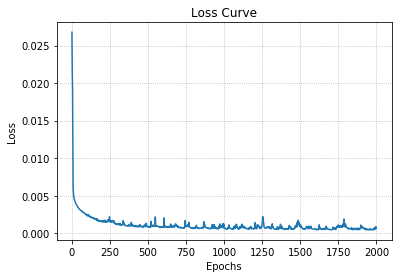

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [28]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


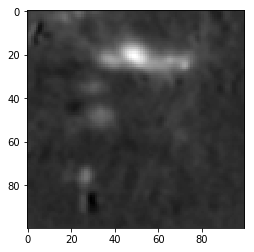

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


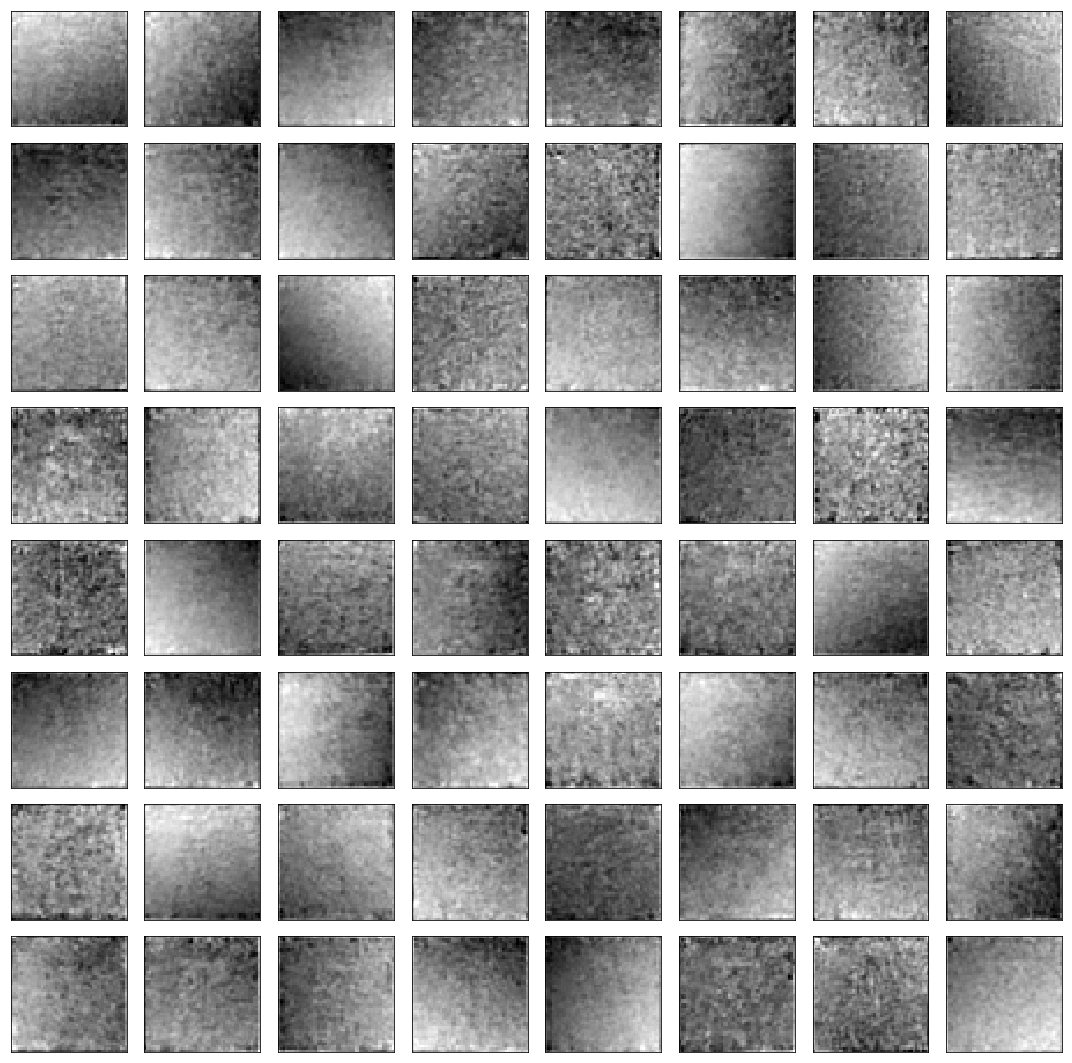

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


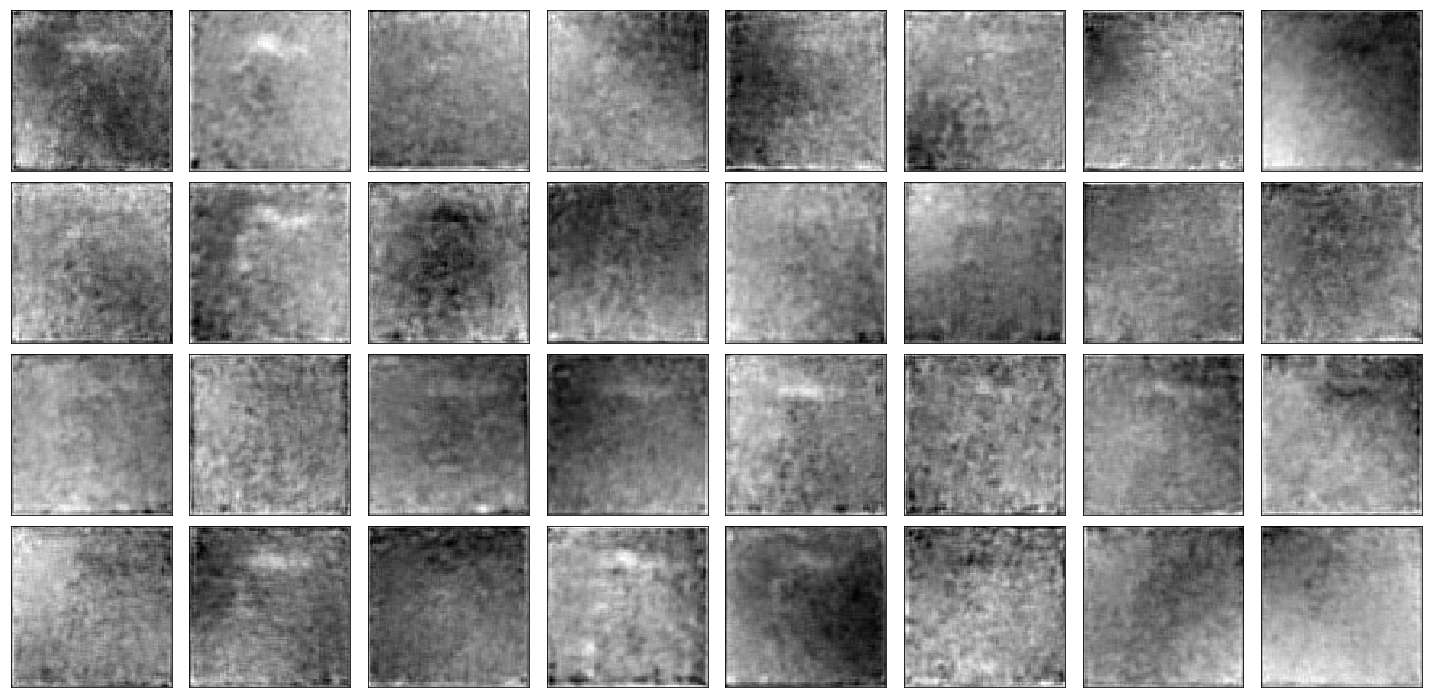

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

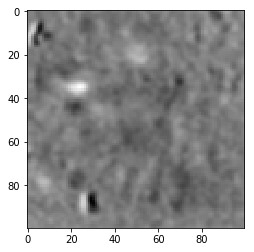

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


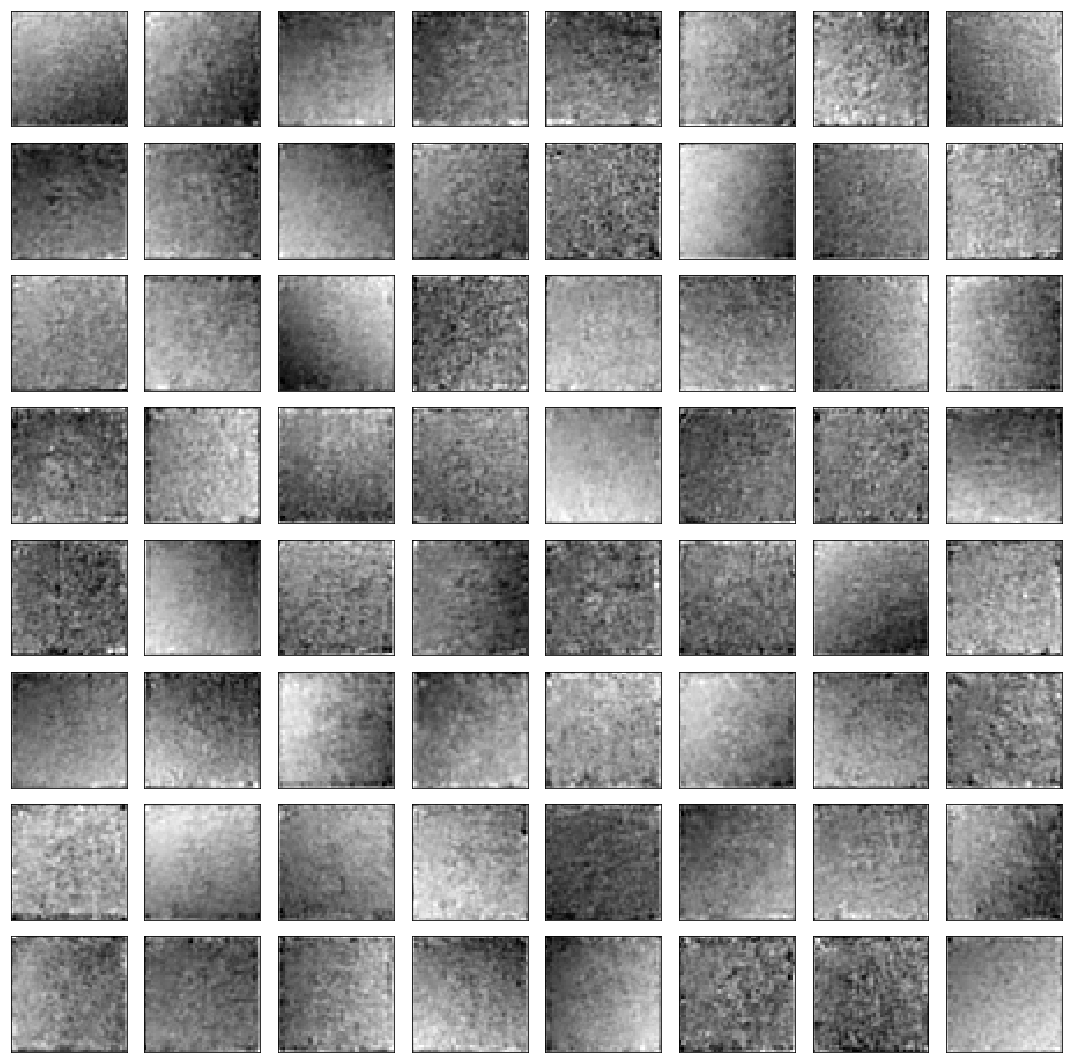

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


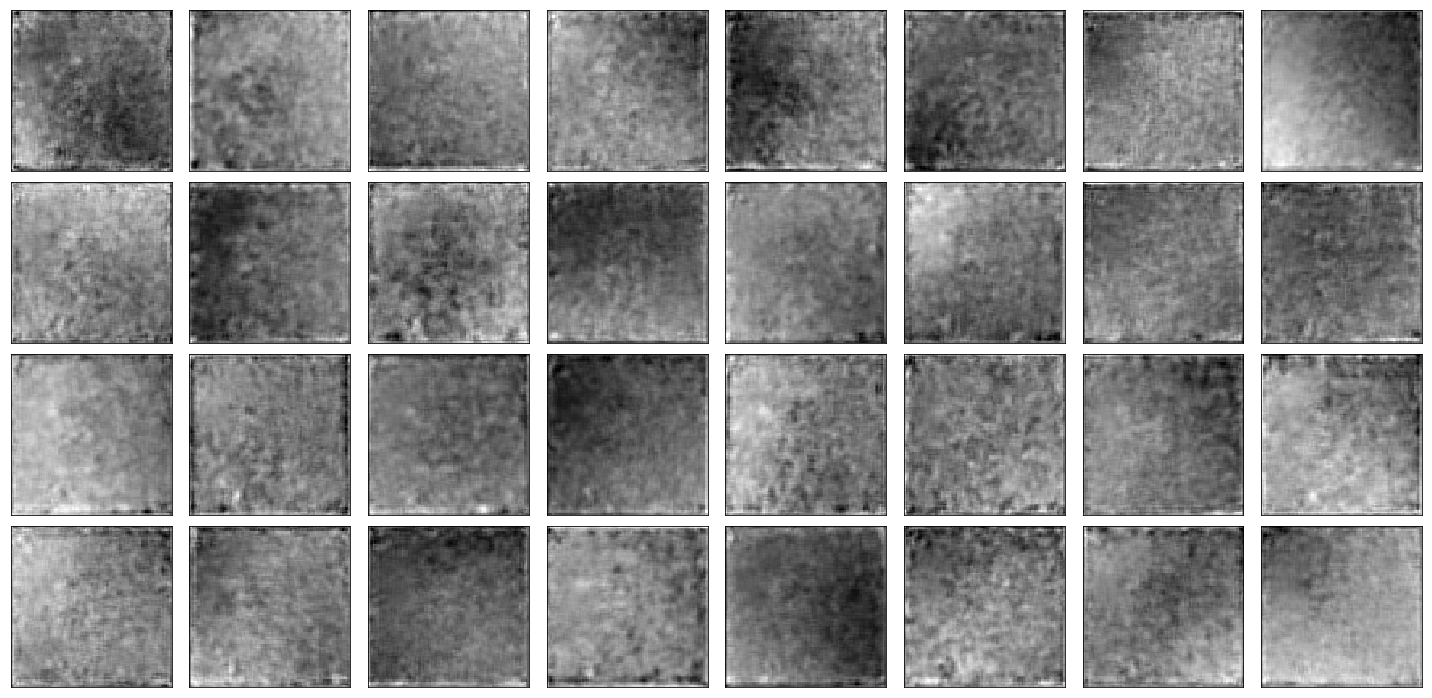

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

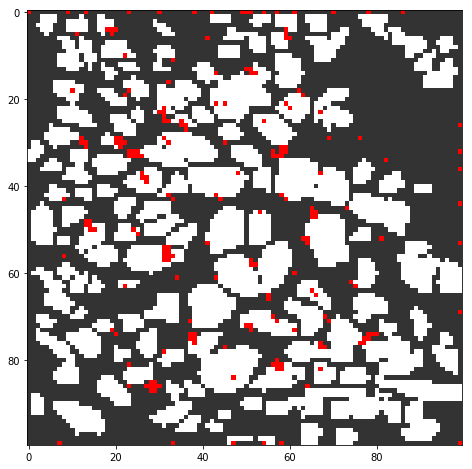

In [47]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

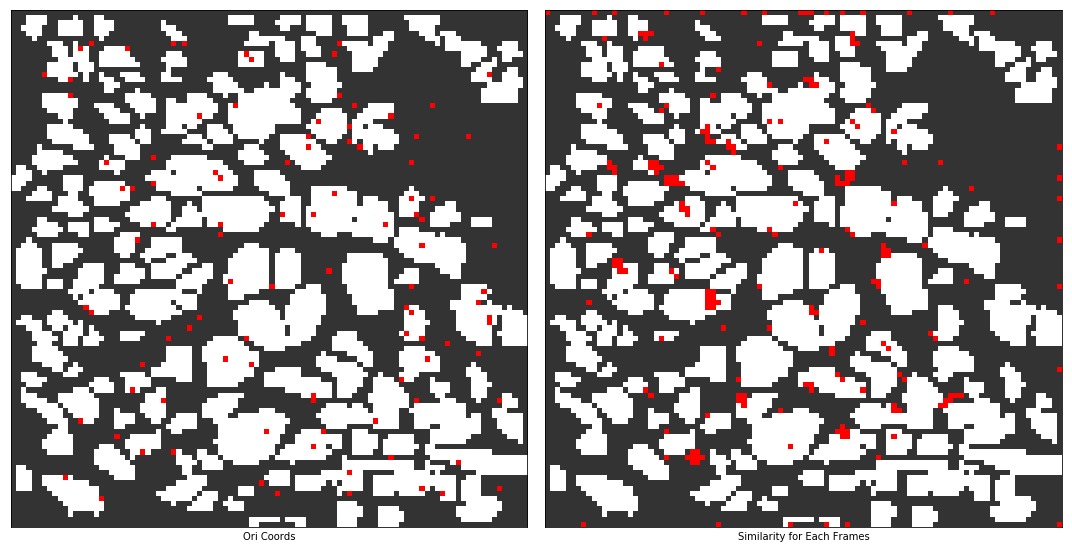

Counts:  201


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)